
# Real-world data coding for neuroscientists (ReCoN)

### MSc in Translational Neuroscience,

### Department of Brain Sciences, Faculty of Medicine,

### Imperial College London

### Contributors: Anastasia Ilina, Cecilia Rodriguez, Marirena Bafaloukou, Katarzyna Marta Zoltowska, Rishideep Chatterjee, Sahar Rahbar, Cynthia Sandor

### Autumn 2025


# 🧠 Computing with Real‑World Medical Data in Python (MSc Translational Neuroscience)
## Tutorial 3 – Tabular data with pandas on Electronic Healthcare Records (EHR)

**Part 3: Statistical Analysis**






## Learning outcomes

**Overall aim**: develop skills for statistical analysis of medical data.

**You will learn:**
- What are hypothesis tests, *p*-values, confidence intervals, effect sizes.
- Understand assumptions behind common statistical tests.
- Learn to check whether the assumptions are met in real-world data.
- How to choose and run appropriate statistical tests for independent measurements across groups.
- How to measure associations between continuous variables in real-world data.
- How to correct for multiple comparisons.
- How to visualise trends effectively. 


## 📚 Supporting material 



> Good resources for learning statistics & Python:
> * [Learning Statistics with Python](https://ethanweed.github.io/pythonbook/landingpage.html)
> * [Khan Academy: Statistics and probability](https://www.khanacademy.org/math/statistics-probability)
> * [Statistics How To](https://www.statisticshowto.com/)
> * [Statistical Methods for Data Science](https://epurdom.github.io/Stat131A/book/)
> * [The nuts and bolts of hypothesis testing](https://pmc.ncbi.nlm.nih.gov/articles/PMC6668281/)

> A lot of useful information (tutorials & examples) can be found in the official documentation of the libraries we use:
> - [📉 Scipy documentation](https://docs.scipy.org/doc/scipy/)
> - [📊 Statsmodels documentation](https://www.statsmodels.org/dev/user-guide.html#background)
> - [📊 Matplotlib documentation](https://matplotlib.org/stable/contents.html)
> - [📉 Seaborn documentation](https://seaborn.pydata.org/index.html)





In [350]:
# === RUN THIS CELL TO (RE)CREATE THE SYNTHETIC DATASET ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


# Fixed: 'ethinicity' -> 'ethnicity'
expected_cols = {"LEDD","sex","years_since_dx","age","updrs_iii","patient_id","ethnicity","BMI"}

# Only (re)create if df isn't already present with expected columns
if not (isinstance(globals().get("df"), pd.DataFrame) and expected_cols.issubset(df.columns)):
    rng = np.random.default_rng(0)
    n = 5000

    # ---- Core table ----
    df = pd.DataFrame({
        "patient_id": [f"P{i:04d}" for i in range(n)],
        "sex": rng.choice(["Male","Female"], size=n, p=[0.55, 0.45]),
        "years_since_dx": rng.uniform(0, 12, size=n).round(2),
        "age": rng.normal(62, 8, size=n).round(1),
        "ethnicity": rng.choice(["White", "Black", "Asian", "Other", ""],
                                size=n, p=[0.70, 0.10, 0.10, 0.05, 0.05]),
        "BMI": rng.normal(27, 4, size=n).round(1),
    })

    # ---- LEDD: base + exponential noise (skewed) ----
    df["LEDD"] = (250 + 50*df["years_since_dx"] + rng.exponential(500, size=n)).clip(0).round(1)

    # ---- UPDRS III: realistic 0–132 with progression + heterogeneity ----
    # Patient-level random intercepts (baseline severity) and slopes (annual change)
    unique_ids = df["patient_id"].unique()
    intercepts = pd.Series(np.clip(rng.normal(20, 6, size=len(unique_ids)), 0, 60), index=unique_ids)
    slopes     = pd.Series(np.clip(rng.normal(2.2, 0.9, size=len(unique_ids)), 0, 5), index=unique_ids)

    alpha = df["patient_id"].map(intercepts).to_numpy()
    beta  = df["patient_id"].map(slopes).to_numpy()
    years = df["years_since_dx"].astype(float).to_numpy()
    eps   = rng.normal(0, 5, size=len(df))  # visit-level noise

    updrs = np.clip(alpha + beta*years + eps, 0, 132)
    df["updrs_iii"] = np.round(updrs, 1)

    # Inject a few impossible outliers (>132) for teaching Winsorisation/capping
    n_out = max(20, int(0.004 * len(df)))  # ~0.4% or at least 20 rows
    idx_out = rng.choice(df.index, size=n_out, replace=False)
    df.loc[idx_out, "updrs_iii"] = np.round(rng.uniform(140, 220, size=n_out), 1)



    # ---- Duplicate visits for some patients (longitudinal flavor) ----
    ###reps = df.sample(200, replace=True, random_state=0).copy()
    ##reps["patient_id"] = reps["patient_id"].sample(frac=1.0, random_state=1).values
    #df = pd.concat([df, reps], ignore_index=True)

    # make LEDD and UPDRS higher on average for men 
    df.loc[df["sex"]=="Male", "LEDD"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())
    df.loc[df["sex"]=="Male", "updrs_iii"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())

    # Make LEDD and UPDRS higher with age and BMI o
    df["LEDD"] *= (1 + 0.03 * (df["age"] - df["age"].mean()))
    df["updrs_iii"] *= (1 + 0.02 * (df["age"] - df["age"].mean()))
    df["LEDD"] *= (1 + 0.02 * (df["BMI"] - df["BMI"].mean()))
    df["updrs_iii"] *= (1 + 0.01 * (df["BMI"] - df["BMI"].mean()))

    # Make LEDD and UPDRS higher in Black and Asian
    df.loc[df["ethnicity"]=="Black", "LEDD"] *= rng.uniform(1.10, 1.25, size=(df["ethnicity"]=="Black").sum())
    df.loc[df["ethnicity"]=="Asian", "LEDD"] *= rng.uniform(1.05, 1.15, size=(df["ethnicity"]=="Asian").sum())
    df.loc[df["ethnicity"]=="Black", "updrs_iii"] *= rng.uniform(1.10, 1.25, size=(df["ethnicity"]=="Black").sum())
    df.loc[df["ethnicity"]=="Other", "updrs_iii"] *= rng.uniform(1.05, 1.15, size=(df["ethnicity"]=="Other").sum())
    


    # ---- Intentional data-entry errors (for cleaning exercises) ----
    # BMI: ×10 typos and negatives
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= 10
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= -1
    # Age: negatives and unrealistic high values
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] *= -1
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] += 108
    

    # ---- MCAR missingness on selected columns ----
    for col, p in [("LEDD", 0.05), ("updrs_iii", 0.10), ("sex", 0.01), ("age", 0.02), ("ethnicity", 0.05)]:
        df.loc[rng.choice(df.index, size=int(p*len(df)), replace=False), col] = np.nan

    # ---- MNAR: LEDD more likely missing when UPDRS is high ----
    high_updrs = df["updrs_iii"] > 45
    # Safeguard: drop NaNs before sampling indices
    high_idx = df.index[high_updrs.fillna(False)]
    if len(high_idx) > 0:
        df.loc[rng.choice(high_idx, size=int(0.3*len(high_idx)), replace=False), "LEDD"] = np.nan

    df.reset_index(drop=True, inplace=True)

    # ---- Summary printout ----
    print(f"Created synthetic dataset with {len(df)} rows")
    print(f"Injected UPDRS>132 outliers: {(df['updrs_iii'] > 132).sum()}")
    print("Missingness (%):")
    print((df[["LEDD","updrs_iii","sex","age","ethnicity","BMI"]].isna().mean()*100).round(1))


In [351]:
# ===== Inject duplicates in three buckets =====
# Counts: adjust as you like
n_exact = 40          # exact row duplicates
n_key   = 160         # same patient_id & years_since_dx (not exact)
n_repeat= 300         # legit repeated visits (different years_since_dx)

df_list = [df]

# --- 1) Exact row duplicates: true copy-paste of entire rows ---
idx_exact = rng.choice(df.index, size=n_exact, replace=False)
exact_dups = df.loc[idx_exact].copy()
df_list.append(exact_dups)

# --- 2) Key duplicates: same patient_id & same years_since_dx but slight entry drift ---
# pick base rows
idx_key = rng.choice(df.index.difference(idx_exact), size=n_key, replace=False)
key_dups = df.loc[idx_key].copy()

# Introduce small, realistic data-entry drift to numeric fields (but keep ID + time the same)
def small_perturb(x, scale):
    return np.round(x + rng.normal(0, scale, size=len(x)), 1)

if "LEDD" in key_dups:
    key_dups["LEDD"] = small_perturb(key_dups["LEDD"], scale=15)     # ±15 mg
if "updrs_iii" in key_dups:
    key_dups["updrs_iii"] = np.clip(small_perturb(key_dups["updrs_iii"], scale=1.5), 0, 220)
if "BMI" in key_dups:
    key_dups["BMI"] = np.round(key_dups["BMI"] + rng.normal(0, 0.3, size=len(key_dups)), 1)

# keep patient_id and years_since_dx unchanged (this makes them key duplicates)
df_list.append(key_dups)

# --- 3) Legit repeats: same patient, NEW years_since_dx (and recomputed fields) ---
# choose patients to get an extra visit
rep_patients = rng.choice(df["patient_id"].unique(), size=n_repeat, replace=False)

# For each chosen patient, create a new visit at a later (or earlier) year_since_dx
reps = df[df["patient_id"].isin(rep_patients)].copy()

# Propose a new time that differs from the current one by ~0.5–2.0 years
delta = rng.uniform(0.5, 2.0, size=len(reps))
sign  = rng.choice([1, -1], size=len(reps), p=[0.8, 0.2])  # mostly later visits
new_years = np.clip(reps["years_since_dx"].astype(float).to_numpy() + sign*delta, 0, 12)
reps["years_since_dx"] = np.round(new_years, 2)

# Age moves with time (if you want): comment out if not desired
if "age" in reps:
    reps["age"] = np.round(reps["age"].astype(float) + sign*delta, 1)

# Recompute LEDD and UPDRS for the *new* visit using the same subject-specific intercept/slope
pid = reps["patient_id"]
alpha_rep = pid.map(intercepts).to_numpy()
beta_rep  = pid.map(slopes).to_numpy()
years_rep = reps["years_since_dx"].astype(float).to_numpy()

# fresh noise terms
eps_rep = rng.normal(0, 5, size=len(reps))
updrs_rep = np.clip(alpha_rep + beta_rep*years_rep + eps_rep, 0, 132)
reps["updrs_iii"] = np.round(updrs_rep, 1)

# recompute LEDD with new years_since_dx
led_noise = rng.exponential(500, size=len(reps))
reps["LEDD"] = (250 + 50*reps["years_since_dx"].astype(float) + led_noise).clip(0).round(1)

# Append legit repeats
df = pd.concat(df_list + [reps], ignore_index=True)

# ---- Quick bookkeeping prints ----
print("\nInjected duplicates summary:")
print(f"  Exact duplicates added:         {len(exact_dups)}")
print(f"  Key-duplicates added:           {len(key_dups)}")
print(f"  Legit repeat visits added:      {len(reps)}")

# (OPTIONAL) Sanity counts right now (pre-missingness/multipliers)
exact_count = df.duplicated(keep=False).sum()
key_count   = df.duplicated(subset=['patient_id','years_since_dx'], keep=False).sum()
print(f"  Current exact-dup rows (counted individually): {exact_count}")
print(f"  Current key-dup rows (same patient+time):      {key_count}")



Injected duplicates summary:
  Exact duplicates added:         40
  Key-duplicates added:           160
  Legit repeat visits added:      300
  Current exact-dup rows (counted individually): 80
  Current key-dup rows (same patient+time):      402


In [ ]:
# delete the df if needed to recreate a fresh version (uncomment and run if needed)
#del df


> In this dataset, each row represents a **visit of a patient with Parkinson’s disease (PD)**.

> The variable `years_since_dx` shows how long it’s been since diagnosis.

> Because LEDD increases with years since diagnosis, you can think of the LEDD values and UPDRS III values as *cross-sectional* medication doses and clinical test results measured at *varying stages* of PD.


## 🧮 Statistical testing - Group Comparisons


### 🧠 Why statistical testing?

Once data are cleaned, we can move to **hypothesis testing** — answering questions like:

* “Are LEDD doses **different between men and women**?”
* “Does **age group** influence LEDD or UPDRS severity?”
* “Is there a **relationship** between LEDD and UPDRS?”

These questions fall into two broad families:

| Question type                 | Example                                                        | Test / Method                       |
| ----------------------------- | -------------------------------------------------------------- | ----------------------------------- |
| **Group comparison**          | Compare LEDD between two or more groups (e.g., male vs female) | *t-test*, *ANOVA*, *Mann–Whitney U* |
| **Correlation / association** | Relationship between two continuous variables                  | *Pearson* or *Spearman* correlation |

---

### ⚖️Comparing groups

Let's consider the first question:
- *“Do male and female patients have different mean LEDD values?”*

When stating this question, we want to infer whether in **geneneral population**, it holds true that men and women are expected to have different mean LEDD values. However, no matter how hard we try, we only will have a **sample** of patients from this population available to us.

Let's say we have collected the sample (the `df` dataframe that we've been using so far). Now, we can visualise the LEDD distributions for men and women within this sample, with mean and median values indicated:

#### 🍎 <span style="color:red; font-weight:bold">Student challenge</span>
<span style="color:red; font-weight:bold">Now your turn!</span>

Use all of the knowledge you've gained so far to: 
1. Clean the data (remove outliers, get rid of duplicates, impute/exclude missing values). Justify your choices. Indicate how many rows remain after each cleaning step. Remember, the tests we are about to do assume **NO REPEATED MEASURES**, so even true longitudinal data should be reduced to one row per patient (e.g., by taking the first visit, or the mean across visits).
2. Visualise the LEDD distributions with mean and median values indicated using both histograms and boxplots/violin plots.

In [ ]:
# Write your code here 

As you can see, the mean and the median LEDD values are slightly higher in men than in women. 

However, we cannot conclude that this difference is **statistically significant** (i.e., it would hold true in the general population) just by looking at the sample.

 It is possible that this difference is just due to **random chance** (natural variability in who ended up in our sample). In other words, if we took another sample of patients (we collected data to create a new dataset), we might find that women have higher LEDD values or there is no difference at all.

To determine whether the observed difference is statistically significant, we can perform a **hypothesis testing**.


> 📝 Group (or **hypothesis**) tests help us determine whether **two or more groups within a population differ** in some quantitative variable, whilst only having a **sample of this population** available for the analysis

For example:

* “Do male and female patients have different mean LEDD values?”

* “Is UPDRS III score higher in older age groups?”

> 💡 This kind of statistical analysis is more broadly referred to as **inferential statistics** — we use a sample to make inferences about the broader population. Or, in other words, we use statistical tools to evaluation whether the statistics we observed indicate some kind of an actual difference, or whether we can see this value just due to random chance. We will cover more examples of inferential statistics beyond group testing in later sections of today's tutorial.



### 🧠 1️⃣ The logic of hypothesis testing 

Every inferential test compares **what we observed** (e.g., a difference between groups) to **what we’d expect just by chance** if there were actually *no real difference*.

We set up:

* **Null hypothesis (H₀):** there is *no true difference* between groups in the population.
* **Alternative hypothesis (H₁):** there *is* a real difference.

Then we:

1. **Compute a test statistic**

   * A **test statistic** is a single number we calculate from the data that captures “how different” the groups look in our sample.
   * Different tests use different statistics:

     * **t** (t-test): standardized difference in means (difference divided by its expected wiggle/SE).
     * **U** (Mann–Whitney/Wilcoxon rank-sum): compares the ranks of values across groups.
     * **W** (Wilcoxon signed-rank): compares paired/ranked differences.
   * Intuition: the test statistic turns your result into a **distance-from-zero** score. Bigger (in the relevant direction) = more surprising if H₀ were true.

2. **Compare that statistic to its null distribution**

   * The **null distribution** is the collection of test-statistic values we’d expect to see **if H₀ were true** (i.e., if any observed difference were just random noise).
   * Where does it come from?

     * **Theory/formulas:** e.g., under H₀ a t-statistic follows a known t-distribution.
     * **Shuffling/permutation:** repeatedly shuffle group labels (as if there’s no real difference) and recompute the statistic to see what “chance alone” produces.
     * **Simulation/bootstrapping:** resample your data in ways consistent with H₀ to build the distribution.
   * Picture it as a curve or histogram of “what chance typically does” to your statistic when there’s truly no effect.

3. **Get a p-value**

   * The **p-value** is the proportion of the null distribution that is **as extreme as** (or more extreme than) your observed test statistic.
   * Small p-value (e.g., < 0.05 - the arbitrary threshold) → your result doesn’t look like something chance would produce very often if H₀ were true → evidence against H₀.



| p-value range | Interpretation                                             | Typical decision                                       |
| ------------- | ---------------------------------------------------------- | ------------------------------------------------------ |
| **p < 0.05**  | The observed difference is *unlikely to be due to chance*. | Reject the null hypothesis — groups probably differ.   |
| **p ≥ 0.05**  | The observed difference is *plausible under the null*.     | Fail to reject the null — no evidence of a difference. |


#### 📍 Key concepts summary
| Concept                         | Plain meaning                                                                                               |
| ------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **Null hypothesis (H₀)**        | No true difference between groups. (e.g., LEDDₘₐₗₑ = LEDD_fₑₘₐₗₑ)                                           |
| **Alternative hypothesis (H₁)** | There is a real difference.                                                                                 |
| **Test statistic**              | A single number measuring how far the sample result is from “no difference” (e.g., *t*, *U*, *W*).          |
| **Null distribution**           | The spread of test-statistic values you’d expect **if H₀ were true**—i.e., what “random chance” looks like. |
| **p-value**                     | How often chance (the null distribution) would yield a statistic as extreme as the one you observed.        |



#### 🌡️ Intuition

> Think of a **thermometer**: the test statistic is the reading (“how hot is this result compared to zero?”).
> * The **null distribution** is the weather forecast for a normal day (“how hot do readings usually get when nothing unusual is happening?”).
> * If today’s reading is way hotter than typical forecasted highs, it’s unlikely to be “just another normal day.”


#### 💊 LEDD example

> Suppose LEDD (mg) averages **550** in Group A and **500** in Group B.
> * Your **test statistic** (t) ≈ (550–500) divided by the expected random wiggle (its standard error).
> * The **null distribution** says what t-values we’d get just by chance if true means were equal.
> * If your observed t sits far out in the tail(s) of that distribution, the **p-value** is small → evidence against H₀.


#### ⚠️ Common pitfalls to look out for!

* A **small p-value ≠ big/important effect**. It just says “unlikely by chance under H₀,” not “clinically large.” Always check **effect size** and **intervals**.
* **p = 0.03** does **not** mean “3% chance H₀ is true.” It means: *if H₀ were true*, you’d see a result this extreme about 3% of the time.
* **Statistical significance ≠ practical significance** — context matters a lot!!!




### 🐒 It's all about the tails!

When we perform hypothesis tests, we need to decide whether we care about differences in one direction or both directions.

* **One-tailed**: you specify a direction (e.g., males have *higher* LEDD than females). You only look at one tail of the null distribution.
* **Two-tailed**: you care about any difference (higher or lower). You look at both tails.


![](https://media.licdn.com/dms/image/v2/D4D12AQFmN9gzAnJvZA/article-cover_image-shrink_423_752/article-cover_image-shrink_423_752/0/1697456211438?e=1763596800&v=beta&t=EjMxB1-t7CWLjLRE9UDgVcDqvwXmAuQQfo2iuqO38_U)

#### ⚖️ Two-tailed test (most common)

Used when you only want to know **if there is any difference** between groups — you *don’t* specify the direction.

| Example question                                   | Hypotheses                                 |
| -------------------------------------------------- | ------------------------------------------ |
| “Is LEDD **different** between males and females?” | H₀: μₘₐₗₑ = μfₑₘₐₗₑ<br>H₁: μₘₐₗₑ ≠ μfₑₘₐₗₑ |

✅ This checks for **any difference** — higher or lower.

🔹 The *t-test* in Python’s `scipy.stats` is **two-tailed by default**.

#### 🎯 One-tailed test

Used when you have a **specific directional hypothesis** — you expect one group’s mean to be **greater** or **less** than the other.

| Example question                                 | Hypotheses                                 |
| ------------------------------------------------ | ------------------------------------------ |
| “Do males have **higher** LEDD than females?”    | H₀: μₘₐₗₑ ≤ μfₑₘₐₗₑ<br>H₁: μₘₐₗₑ > μfₑₘₐₗₑ |
| “Do older patients have **lower** UPDRS scores?” | H₀: μₒₗd ≥ μyoung<br>H₁: μₒₗd < μyoung     |

✅ Use a one-tailed test **only if you had a clear directional prediction before collecting data**.
❌ Don’t use it just because it gives a smaller p-value!



#### 💡 Practical tip

| If you…                                               | Then use…                                    |
| ----------------------------------------------------- | -------------------------------------------- |
| Just want to know *whether* groups differ             | **Two-tailed** test                          |
| Have a pre-specified, directional clinical hypothesis | **One-tailed** test                          |
| Are exploring data without strong prior expectation   | **Always two-tailed** (safer, more standard) |

---


### ⚖️ 3️⃣ Before we perform a group test - we must check assumptions!

I know, as if all this wasn’t complicated enough already! 

However, to get valid results from a group test, we must ensure our data meet certain **assumptions** if the test relies on them.

Most **parametric tests** (like the *t-test*) assume that:

1. Data in each group are **approximately normal** (bell-shaped).
2. Groups have **similar variances** (spread).

If these assumptions are violated, we use **non-parametric** alternatives (which rely on ranks, not raw values).

![](https://scontent-lhr8-1.xx.fbcdn.net/v/t39.30808-6/219342105_1468957566809865_3769416112123561335_n.png?_nc_cat=107&ccb=1-7&_nc_sid=127cfc&_nc_ohc=ehKewqT9f24Q7kNvwEOXHxt&_nc_oc=AdmysF2zJ7B3AJyVtYDnwkHlFsdhg09u1H2-IeEwK835hvZa62yrUTmZ58E4bekstWM&_nc_zt=23&_nc_ht=scontent-lhr8-1.xx&_nc_gid=OPOqQto0w51crkB5RKemJA&oh=00_AfcyKipqmD8jqThcUQelktCTaM9pLzUTpolN89jfDg6fDA&oe=68F47604)

### ⚙️ 5️⃣ Practical example — Normality and variance testing in LEDD by sex

To check for the normality of the distributions, we can also use visual methods like histograms and Q-Q plots.

#### 📈 Understanding Q–Q Plots (Quantile–Quantile Plots)

A **Q–Q plot** (short for *Quantile–Quantile plot*) is a graphical tool used to **compare the shape of your data distribution** to a **theoretical distribution** — usually the **normal distribution**.

It helps you check visually whether your variable (like LEDD) is approximately **normally distributed**.

The Q–Q plot compares **your data’s quantiles** to those of a **perfectly normal distribution** with the same mean and standard deviation.


### 🧮 2️⃣ How a Q–Q plot works

Each point in the Q–Q plot represents:

* **x-axis** → the *expected quantile* from a normal distribution
* **y-axis** → the *observed quantile* from your dataset

If your data are perfectly normal:

* All points will fall **approximately on the 45° diagonal line**.

### 👁️ 3️⃣ How to interpret the Q–Q plot

| Pattern                                                                     | What it means                                          | Interpretation                                      |
| --------------------------------------------------------------------------- | ------------------------------------------------------ | --------------------------------------------------- |
| Points follow a **straight 45° line**                                       | Your data are approximately **normal**                 | Safe to use parametric tests (e.g. t-test)          |
| **S-shaped curve** (points below line in left tail and above in right tail) | **Right-skewed** (long tail to the right)              | LEDD often shows this pattern                       |
| **Inverted S-shape** (points above line on left, below on right)            | **Left-skewed** (long tail to the left)                | Less common in biomedical data                      |
| **Points far from the line at the ends**                                    | **Heavy tails** (outliers or leptokurtic distribution) | Variability is higher than expected under normality |

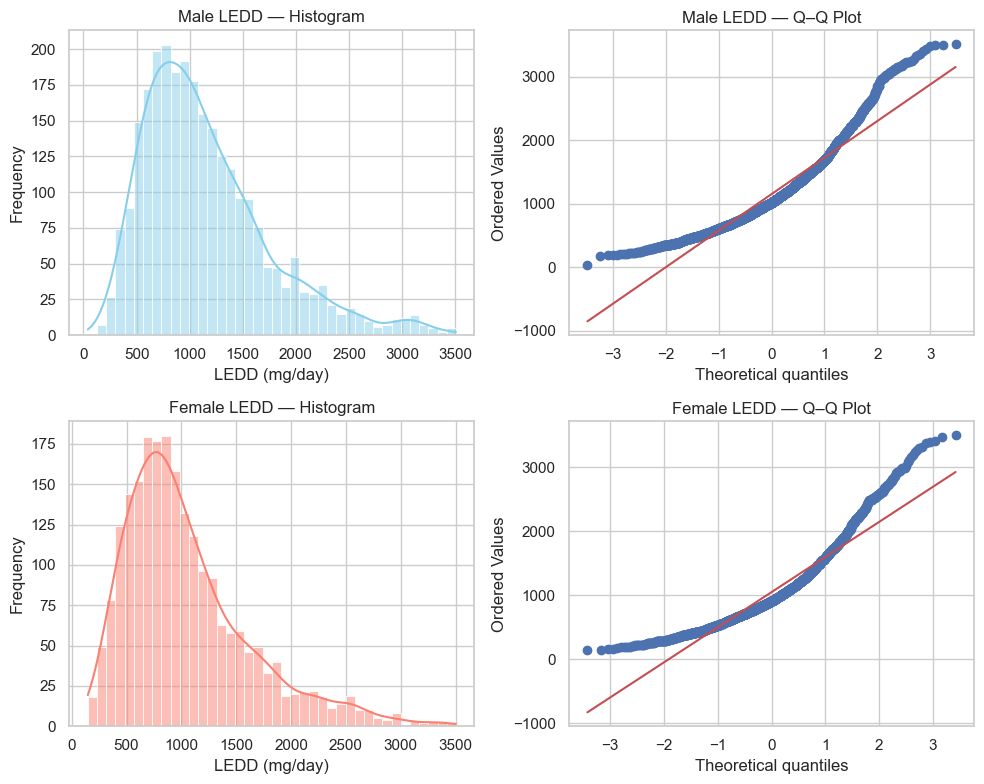

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# --- Prepare the data ---
male_ledd = df_clean.loc[df_clean["sex"]=="Male", "LEDD"].dropna()
female_ledd = df_clean.loc[df_clean["sex"]=="Female", "LEDD"].dropna()

# --- Set up subplots ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# === 1. Histogram for males ===
sns.histplot(male_ledd, bins=40, kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Male LEDD — Histogram")
axes[0,0].set_xlabel("LEDD (mg/day)")
axes[0,0].set_ylabel("Frequency")

# === 2. Q–Q plot for males ===
stats.probplot(male_ledd, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Male LEDD — Q–Q Plot")

# === 3. Histogram for females ===
sns.histplot(female_ledd, bins=40, kde=True, color="salmon", ax=axes[1,0])
axes[1,0].set_title("Female LEDD — Histogram")
axes[1,0].set_xlabel("LEDD (mg/day)")
axes[1,0].set_ylabel("Frequency")

# === 4. Q–Q plot for females ===
stats.probplot(female_ledd, dist="norm", plot=axes[1,1])
axes[1,1].set_title("Female LEDD — Q–Q Plot")

plt.tight_layout()
plt.show()



If LEDD were perfectly normal, points in your Q–Q plot would form a near-straight line.
But LEDD typically has a **long right tail** — a few patients on very high doses —
so the **upper quantiles bend upward**, forming an S-shape.

That’s a visual cue to use **non-parametric** tests like the Mann–Whitney U test instead of a t-test.


| Plot type     | What to look for                               | Interpretation                                   |
| ------------- | ---------------------------------------------- | ------------------------------------------------ |
| **Histogram** | Bell-shaped, roughly symmetric curve           | Data approximately normal                        |
|               | Right-skewed (long tail to the right)          | Common for LEDD — higher doses in a few patients |
| **Q–Q Plot**  | Points fall close to the 45° line              | Normal distribution                              |
|               | Curved away from the line, especially in tails | Non-normal (skewed or heavy-tailed)              |


As an example, let's compare it to the BMI distribution, which is more symmetric and closer to normal.


Rows after removing BMI outliers: 4932
BMI range kept: 14.9 – 39.0


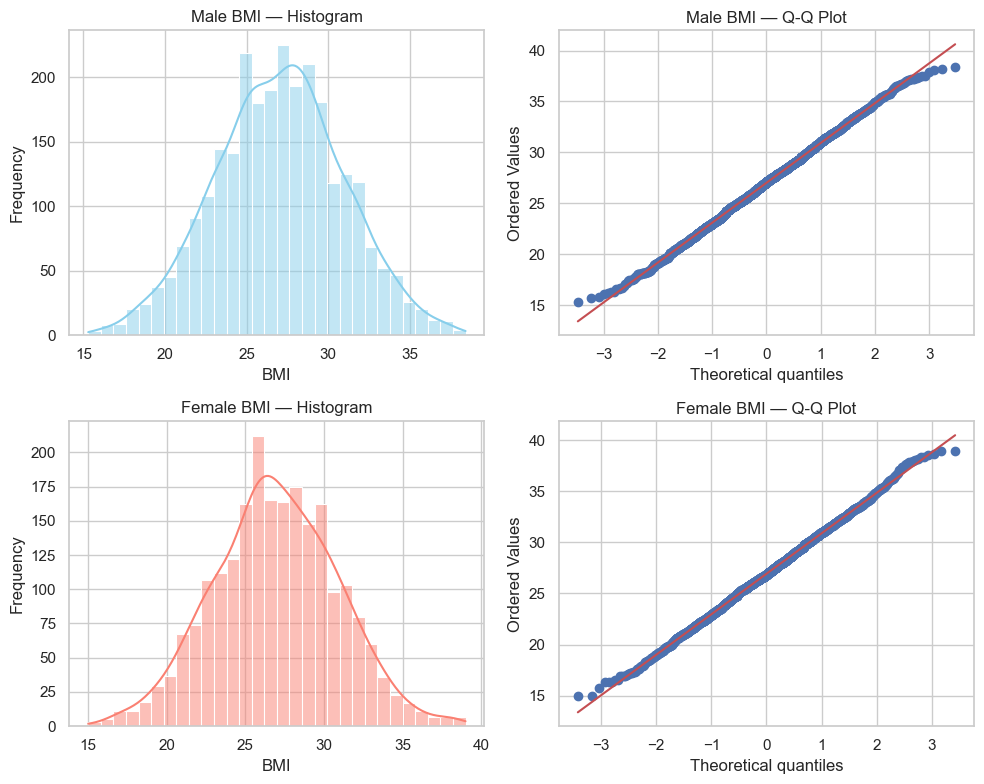

In [356]:
# Do the same for BMI by sex
# remove outlisers using the SD rule (mean ± 3*SD)
bmi_mean = df_clean["BMI"].mean()
bmi_std = df_clean["BMI"].std()
bmi_lower, bmi_upper = bmi_mean - 3*bmi_std, bmi_mean + 3*bmi_std
df_clean = df_clean[(df_clean["BMI"] >= bmi_lower) & (df_clean["BMI"] <= bmi_upper)].copy()
print(f"Rows after removing BMI outliers: {len(df_clean)}")
print(f"BMI range kept: {bmi_lower:.1f} – {bmi_upper:.1f}")

# --- Prepare the data ---
male_bmi = df_clean.loc[df_clean["sex"]=="Male", "BMI"].dropna()    
female_bmi = df_clean.loc[df_clean["sex"]=="Female", "BMI"].dropna()

# --- Set up subplots ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# === 1. Histogram for males ===       
sns.histplot(male_bmi, bins=30, kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Male BMI — Histogram")
axes[0,0].set_xlabel("BMI")
axes[0,0].set_ylabel("Frequency")   
# === 2. Q
#–Q plot for males ===  
stats.probplot(male_bmi, dist="norm", plot=axes[0,1])
axes[0,1].set_title("Male BMI — Q-Q Plot")  
# === 3. Histogram for females
sns.histplot(female_bmi, bins=30, kde=True, color="salmon", ax=axes[1,0])
axes[1,0].set_title("Female BMI — Histogram")
axes[1,0].set_xlabel("BMI")
axes[1,0].set_ylabel("Frequency")
# === 4. Q–Q plot for females ===
stats.probplot(female_bmi, dist="norm", plot=axes[1,1])
axes[1,1].set_title("Female BMI — Q-Q Plot")
plt.tight_layout()
plt.show()




<span style="color:orange;"> However, **visual checks are NOT ALWAYS enough**. Based on the sample size, we might also need to perform a **formal statistical test for normality**. </span>

There are two common normalisty tests, that can be easily accessed in Python using SciPy library:

| Test                         | Function                  | Hypothesis                               | When to use                                            |
| ---------------------------- | ------------------------- | ---------------------------------------- | ------------------------------------------------------ |
| **Shapiro–Wilk**             | `stats.shapiro(x)`        | H₀: data come from a normal distribution | Default choice for small/medium samples (<5000)        |
| **Kolmogorov–Smirnov (K-S)** | `stats.kstest(x, 'norm')` | H₀: sample follows a normal distribution | Alternative; can also test against other distributions |

Interpretation:

* **p ≥ 0.05** → fail to reject normality → data are approximately normal.
* **p < 0.05** → reject normality → data deviate significantly from normal.

### ↔️ What about the variances?
As you remember, the second common assumption of the parametrics tests (like the t-test) is that **the groups have similar variances** (spread). This can be formally tested using **Levene’s test**.
| Test            | Function                     | Hypothesis                               | When to use                                      |
| --------------- | ---------------------------- | ---------------------------------------- | ------------------------------------------------ |
| **Levene’s test** | `stats.levene(x1, x2, ...)` | H₀: group variances are equal             | Default choice for checking homogeneity of variances |  


**Alternative (H₁):** at least one group variance differs.
**Interpretation:**

* **p ≥ 0.05** → fail to reject H₀ → no evidence that variances differ.
* **p < 0.05** → reject H₀ → variances likely differ.

**Why it matters:** the *classic* two-sample t-test assumes equal variances. If that’s doubtful, use **Welch’s t-test** (`ttest_ind(..., equal_var=False)`), which is robust to unequal variances.

**Robust variant:** Levene can use different “centers.”

* `center='mean'` (default) is fine most of the time.
* `center='median'` (aka **Brown–Forsythe**) is **more robust** when data have outliers or are a bit skewed.


> **⚠️ A quick note about p-values in assumption checks**
>
> * In **group tests** (e.g., t-test), the p-value asks: *“If there were **no true group difference**, how often would we see a result this extreme?”*
> * In **assumption tests** (e.g., Shapiro–Wilk, K-S), the p-value asks: *“If the data were **truly normal**, how often would we see a sample that looks this unusual?”*
>
> So a **small p** in Shapiro–Wilk does **not** mean groups differ; it means your *shape assumption* (normality) looks unlikely. Conversely, a **large p** doesn’t prove normality—it just means you don’t have evidence against it.

In [357]:
# Split LEDD values by sex
male_ledd = df_clean.loc[df_clean["sex"]=="Male", "LEDD"].dropna()
female_ledd = df_clean.loc[df_clean["sex"]=="Female", "LEDD"].dropna()

# --- Shapiro–Wilk test for normality ---
# Shapiro is recommended up to n≈5000. If larger, sample for the test but plot everything.
n_samp = 5000 if len(male_ledd) > 5000 else len(male_ledd)
male_sample = male_ledd.sample(n_samp, random_state=1, replace=False)

n_samp = 5000 if len(female_ledd) > 5000 else len(female_ledd)
female_sample = female_ledd.sample(n_samp, random_state=1, replace=False)

normality_results = {
    "male": stats.shapiro(male_sample),
    "female": stats.shapiro(female_sample),
}

print("Shapiro–Wilk normality test results (W, p-value):")
for sex, res in normality_results.items():
    print(f"  {sex}: W={res.statistic:.4f}, p={res.pvalue:.4f}")

# --- Kolmogorov–Smirnov caution ---
# kstest with mean/std estimated from the same data is *not* the exact KS null (needs Lilliefors correction).
# Prefer Shapiro, D’Agostino-Pearson (stats.normaltest), or Anderson–Darling (stats.anderson).
ks_male = stats.kstest(male_ledd, "norm", args=(male_ledd.mean(), male_ledd.std(ddof=1)))
ks_female = stats.kstest(female_ledd, "norm", args=(female_ledd.mean(), female_ledd.std(ddof=1)))
print("\nKolmogorov–Smirnov test results (D, p-value):")
print(f"  Male: D={ks_male.statistic:.4f}, p={ks_male.pvalue:.4f}")
print(f"  Female: D={ks_female.statistic:.4f}, p={ks_female.pvalue:.4f}")

# if the p-values are below 0.05, we reject the null hypothesis of normality
if ks_male.pvalue < 0.05 or ks_female.pvalue < 0.05:
    print("\nAt least one group deviates significantly from normality (p < 0.05).")
else:
    print("\nNo significant deviation from normality detected (p >= 0.05).")

# --- Levene’s test for equality of variances ---
# Use center='median' for the Brown–Forsythe variant (more robust to skew/outliers)
levene_stat, levene_p = stats.levene(male_ledd, female_ledd, center='median')
print(f"\nLevene/Brown–Forsythe (center=median): W={levene_stat:.4f}, p={levene_p:.4f}")

if levene_p < 0.05:
    print("Variances differ significantly between groups (p < 0.05).")
else:
    print("No significant difference in variances detected (p >= 0.05).")


Shapiro–Wilk normality test results (W, p-value):
  male: W=0.9169, p=0.0000
  female: W=0.9069, p=0.0000

Kolmogorov–Smirnov test results (D, p-value):
  Male: D=0.0954, p=0.0000
  Female: D=0.1091, p=0.0000

At least one group deviates significantly from normality (p < 0.05).

Levene/Brown–Forsythe (center=median): W=4.3886, p=0.0362
Variances differ significantly between groups (p < 0.05).


### ⚔️ The number game — sample size matters!

* **Sample size sensitivity:** With **large n**, tiny, harmless deviations from normality will often give **small p** (over-sensitive). With **small n**, the test may **miss** real deviations (low power). Always pair with **visual checks** (histogram/QQ-plot).

* **K-S caveat (SciPy):** `stats.kstest(x, 'norm')` tests against the **standard** normal (mean 0, sd 1). Standardize first or pass your sample’s mean/sd:
  `stats.kstest(x, 'norm', args=(np.mean(x), np.std(x, ddof=1)))`. Many prefer **Shapiro–Wilk** or **D’Agostino–Pearson** (`stats.normaltest`) or **Anderson–Darling** (`stats.anderson(x, 'norm')`) for normality.

* Robust defaults > pre-testing:
Because Welch’s t-test handles unequal variances well, many analysts skip Levene as a gatekeeper and simply report Welch. Use Levene/Brown–Forsythe as a diagnostic and for explaining assumptions to learners.


### What counts as “small” vs “large” here?

| Per-group sample size            | What to expect                                                                                                 | Practical advice                                                                                                                                             |
| -------------------------------- | -------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **n < 30** (small)               | Normality tests have **low power** → real non-normality may go undetected.                                     | Use **QQ-plots + Shapiro–Wilk**; be cautious. Prefer **Welch’s t-test**; consider **transformations** or **rank tests** if shapes look bad/outliers present. |
| **30 ≤ n ≤ 200** (moderate)      | Tests have decent power; mild deviations are OK for t-tests.                                    | Pair **Shapiro / D’Agostino** with visuals. Focus on **outliers/skew** more than tiny p-values.                                                              |
| **200 < n ≤ 500** (large)        | Tests start to be **over-sensitive**: tiny, harmless wiggles → significant p.                                  | Prioritize **QQ-plots** and **robustness to variance differences** (Welch’s t-test). Don’t overrely on small p from normality tests.                                                |
| **500 < n ≤ 5,000** (very large) | Almost any deviation triggers **p < .05**. Shapiro still OK computationally up to ~5k but often uninformative. | you may run a formal normality test (like Shapiro) on a small random subset (e.g., ≤500) to avoid the “everything is significant” problem at large n. But treat that p-value as auxiliary; your main checks should be visuals (QQ-plots/histograms) and robust methods (e.g., Welch’s t-test).                                                                       |
| **n > 5,000** (huge)             | Formal normality te|sts become **universally significant**; Shapiro is **not recommended** for such sizes.      | Skip formal normality tests; use **QQ-plots**, **robust estimators**, and **Welch’s t-test**. Emphasize **practical** vs **statistical** significance.       |







### 🔎 Summary of assumption checks to justify your choice

* **Shape:** QQ-plots per group; look for straight-ish lines (heavy tails/outliers → prefer rank tests).
* **Normality p-values:** Helpful at small/moderate *n*; at large *n* they often flag harmless deviations.
* **Variance similarity:** **Brown–Forsythe (median-centered Levene)** is robust; if unequal, Welch (2 groups) or Kruskal–Wallis (k groups) are safer.
* Briefly **state what you checked** when you report results.



## 🔍 6️⃣ Choosing the right group test (with Student vs Welch, Mann–Whitney, ANOVA & Kruskal–Wallis)

### ✅ Independent (non-repeated) designs

* **Two groups:** Prefer **Welch’s t-test**; use **Student’s t-test** only when *both* groups look ~normal, **variances are similar**, and **sample sizes are reasonably balanced**. If shapes are clearly non-normal/heavy-tailed → **Mann–Whitney U**.
* **≥3 groups:** **One-way ANOVA** when residuals look ~normal and variances are similar; otherwise **Kruskal–Wallis**. (You’ll cover repeated-measures ANOVA/LME in the next notebook.)

**What “independent (non-repeated)” means—and why it matters**

* Each participant contributes **at most one observation per group/condition**.
* Observations are **not clustered** (no repeated visits per patient, no family/centre clustering, etc.).
* Violating independence (e.g., counting the same patient twice) **inflates Type I error** and biases estimates.
* If you have repeated measures within patients, either **aggregate to one value** or use **repeated-measures / mixed-effects models** (covered next).

---

### 📘 Quick guide

| Situation                                                              | Test                 | Hypotheses                                                  | Assumptions                                                                           | What p tests                      | Effect to report                  |
| ---------------------------------------------------------------------- | -------------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------------------- | --------------------------------- | --------------------------------- |
| **Two groups, normal-ish**; variances **similar** & sizes **balanced** | **Student’s t-test** | H₀: μ₁=μ₂                                                   | Independent; **equal variances**; normal-ish ( Central Limit Theorem helps for large n);                                      | Mean difference                   | Means + **95% CI**                |
| **Two groups, normal-ish or large n**; variances maybe unequal         | **Welch’s t-test**   | H₀: μ₁=μ₂                                                   | Independent;**no equal-variance assumption**; normal-ish (Central Limit Theorem helps for large n);  | Mean difference                   | Means + **95% CI**                |
| **Two groups, strong non-normality / outliers**                        | **Mann–Whitney U**   | H₀: distributions equal (≈ medians equal if shapes similar) | Independent; ordinal/numeric                                                          | Shift in distributions            | Medians (opt. Hodges–Lehmann)     |
| **≥3 groups, normal-ish & similar variances**                          | **One-way ANOVA**    | H₀: all means equal                                         | Independent; residuals ~normal; **homogeneous variances**                             | At least one mean differs         | Means (opt. η²)                   |
| **≥3 groups, non-normal and/or unequal variances**                     | **Kruskal–Wallis**   | H₀: distributions equal (≈ medians equal if shapes similar) | Independent; ordinal/numeric                                                          | At least one distribution differs | Medians (post-hoc Dunn if needed) |

> 🧪 **Reality check:** Welch’s t-test is a safe default for 2-group means. Student’s t-test is fine when equal variances are credible (balanced design, similar spreads), but **you don’t need it** if you already use Welch.

---

### 🌪️ Why Shapiro can say “non-normal” but a t-test is still OK 

* **What Shapiro tests:** the **raw data** shape.
* **What t-tests need:** the **sampling distribution of the mean difference** to be roughly normal.
* **Central Limit Theorem (CLT):** with **large n** (e.g., hundreds to thousands **per group**), the mean (and the **difference of means**) is approximately normal **even if raw data are skewed**, provided variance is finite and observations are independent.
* **Implication:** It’s common for Shapiro to be **significant** (reject normality) at large n while **Welch/Student t-tests** remain valid for comparing means. In such cases, rely more on **QQ-plots** and **variance checks** than on normality p-values.

### 📏 Sample-size guidance (per group)

* **Small:** *n* < 30 → normality tests **miss** problems; lean on QQ-plots; prefer Welch; consider rank tests if shapes are bad.
* **Moderate:** 30 ≤ *n* ≤ 200 → tests useful; combine with visuals.
* **Large:** *n* > 200 (esp. > 500) → normality p-values flag trivial deviations; rely on QQ-plots, Welch/ANOVA vs Kruskal by **shape/variance**, and report effect sizes + CIs.
* **Huge (≈ > 5,000):** skip formal normality tests; use visuals + robust procedures.


### 🧱 Caution: heavy tails & outliers

* If there are **extreme outliers/heavy tails** (e.g., uncleaned data where a few huge values can dominate the mean), the CLT alone won’t protect your estimate from being **pulled**.
* In those cases, prefer **Welch’s t-test** over Student (it’s robust to unequal variances) and consider a **rank-based test (Mann–Whitney)** if the mean is clearly not representative.
* Always show **QQ-plots** and report **robust summaries** (e.g., medians or trimmed means) alongside your inference when tails look long/heavy.

---




## Quick-start: group difference tests

### 1) Two independent groups — **Welch’s t-test** (robust default)
Use when comparing means for two groups; safe if variances differ.

In [358]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Helper function to convert p-values to significance stars

def p_to_stars(p):
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 0.05: return "*"
    return "ns"  # not significant

def add_sig_bracket(ax, x1, x2, y, h, text, lw=1.5, fs=12):
    """
    Draws a bracket with 'text' (e.g., stars) between positions x1 and x2 at height y.
    h is the bracket height.
    """
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1 + x2) / 2, y + h, text, ha="center", va="bottom", fontsize=fs)


Welch t-test: t=6.030, p=1.77e-09
Means: Male 1151.4, Female 1050.3


/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_47760/683947092.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([x, y], labels=["Male","Female"], showmeans=False)


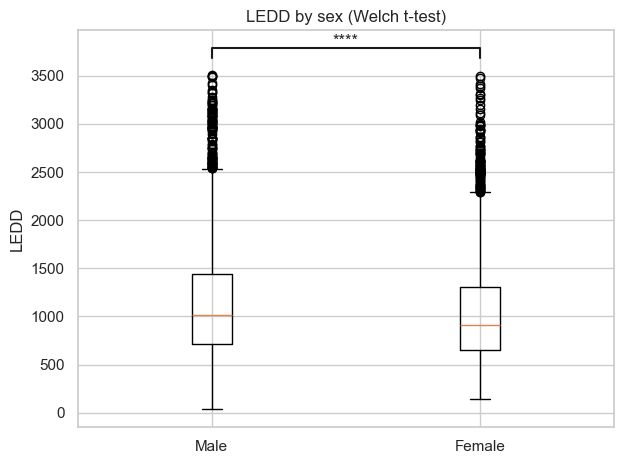

In [359]:
# Example: LEDD by sex
x = df_clean.loc[df_clean["sex"]=="Male",   "LEDD"].dropna().astype(float)
y = df_clean.loc[df_clean["sex"]=="Female", "LEDD"].dropna().astype(float)

# Test
t, p = stats.ttest_ind(x, y, equal_var=False)  # Welch
print(f"Welch t-test: t={t:.3f}, p={p:.3g}")
print("Means: Male {:.1f}, Female {:.1f}".format(x.mean(), y.mean()))

# Boxplot
fig, ax = plt.subplots()
bp = ax.boxplot([x, y], labels=["Male","Female"], showmeans=False)

ax.set_ylabel("LEDD")
ax.set_title("LEDD by sex (Welch t-test)")

# Star
ymax = np.nanmax([x.max(), y.max()])
ymin = np.nanmin([x.min(), y.min()])
y = ymax + 0.05*(ymax - ymin + 1)   # starting height
h = 0.03*(ymax - ymin + 1)          # bracket height
add_sig_bracket(ax, 1, 2, y, h, p_to_stars(p))

plt.tight_layout()
plt.show()



### 2) Two independent groups — **Mann–Whitney U** (non-parametric)

Use when data are clearly non-normal, have outliers, or are ordinal.

Mann–Whitney U: U=3398002, p=1.09e-14
Medians: Male 35.0, Female 32.0


/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_47760/2900168342.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([x, y], labels=["Male","Female"], showmeans=False)


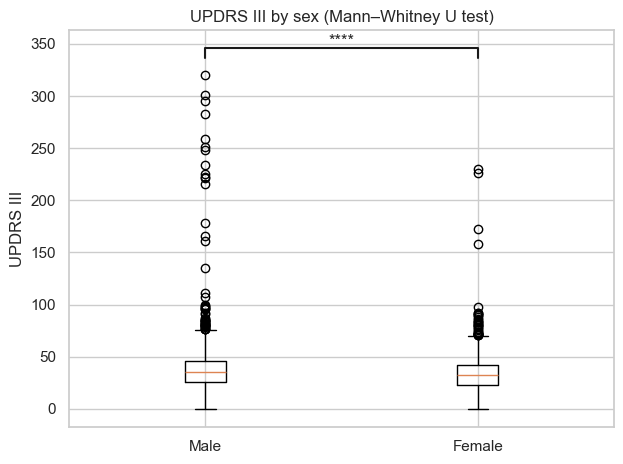

In [360]:
# Same x, y as above

# let's use it on updrs_iii scores 
x, y = df_clean.loc[df_clean["sex"]=="Male",   "updrs_iii"].dropna().astype(int), \
         df_clean.loc[df_clean["sex"]=="Female", "updrs_iii"].dropna().astype(int)

u, p = stats.mannwhitneyu(x, y, alternative="two-sided")
print(f"Mann–Whitney U: U={u:.0f}, p={p:.3g}")
print("Medians: Male {:.1f}, Female {:.1f}".format(x.median(), y.median()))

# Boxplot
fig, ax = plt.subplots()
bp = ax.boxplot([x, y], labels=["Male","Female"], showmeans=False)
ax.set_ylabel("UPDRS III")
ax.set_title("UPDRS III by sex (Mann–Whitney U test)")  

# Star
ymax = np.nanmax([x.max(), y.max()])
ymin = np.nanmin([x.min(), y.min()])
y = ymax + 0.05*(ymax - ymin + 1)   # starting height
h = 0.03*(ymax - ymin + 1)          # bracket height
add_sig_bracket(ax, 1, 2, y, h, p_to_stars(p))  
plt.tight_layout()
plt.show()

### 3) Three or more independent groups — **One-way ANOVA**

Use when comparing means across ≥3 groups.

One-way ANOVA: F=0.84, p=0.472
Group means:
  Asian: 26.8 (n=503)
  Black: 26.8 (n=538)
  Other: 27.0 (n=240)
  White: 27.0 (n=3427)


/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_47760/1147236955.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showmeans=False)


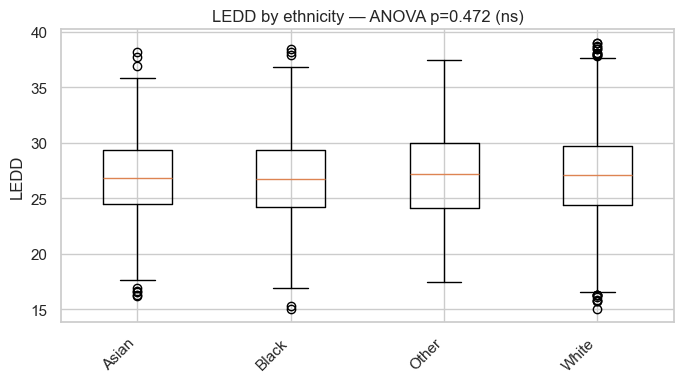

In [361]:
from scipy import stats

# Example: BMI by ethnicity (skip blanks/NaNs)
mask = df_clean["ethnicity"].notna() & (df_clean["ethnicity"]!="")
groups = [g["BMI"].dropna().astype(float).values
          for _, g in df_clean.loc[mask].groupby("ethnicity")]

F, p = stats.f_oneway(*groups)
print(f"One-way ANOVA: F={F:.2f}, p={p:.3g}")
print("Group means:")
for (eth, g) in df_clean.loc[mask].groupby("ethnicity"):
    print(f"  {eth}: {g['BMI'].mean():.1f} (n={len(g)})")


grp = df_clean.loc[mask, ["ethnicity","LEDD"]].dropna()
labels = [str(k) for k, _ in grp.groupby("ethnicity")]



fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(groups, labels=labels, showmeans=False)
ax.set_ylabel("LEDD")
ax.set_title(f"LEDD by ethnicity — ANOVA p={p:.3g} ({p_to_stars(p)})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()



### 4) Three or more independent groups — **Kruskal–Wallis** (non-parametric)

Use when ≥3 groups and you don’t want to assume normality/equal variances.


Kruskal–Wallis: H=45.17, p=8.53e-10
Group medians:
  Asian: 1000.9 (n=503)
  Black: 1101.1 (n=538)
  Other: 933.4 (n=240)
  White: 947.8 (n=3427)


/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/ipykernel_47760/808310677.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels)


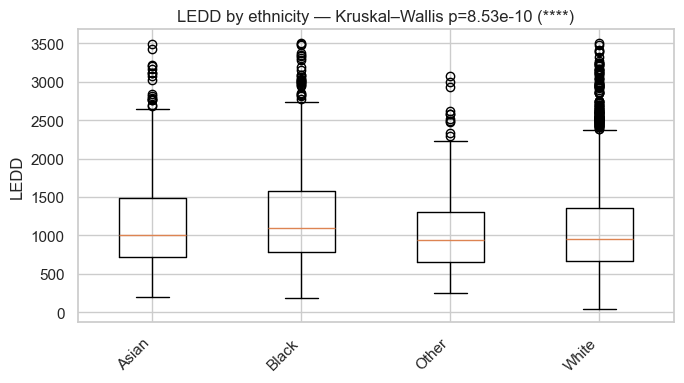

In [362]:
from scipy import stats
mask = df_clean["ethnicity"].notna() & (df_clean["ethnicity"]!="")
groups = [g["LEDD"].dropna().astype(float).values
          for _, g in df_clean.loc[mask].groupby("ethnicity")]

H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis: H={H:.2f}, p={p:.3g}")
print("Group medians:")
for (eth, g) in df_clean.loc[mask].groupby("ethnicity"):
    print(f"  {eth}: {g['LEDD'].median():.1f} (n={len(g)})")


fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(groups, labels=labels)
ax.set_ylabel("LEDD")
ax.set_title(f"LEDD by ethnicity — Kruskal–Wallis p={p:.3g} ({p_to_stars(p)})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()




### 🎛️ Degrees of freedom (df): — what they are & how we get them

**What it means (intuition).**
Degrees of freedom are the number of **independent pieces of information** your data still have **available to vary** *after* you’ve used some of them to estimate things (like a mean). Every time you estimate a parameter, you “spend” some freedom.

**A tiny example.**
Imagine three numbers must average 10. If you pick the first two freely (say 8 and 11), the third one is **forced** to be 11 to keep the average 10. Only **two** numbers were truly free to vary → **df = 2**.

**Why df matters.**

* The reference curves behind many tests (the *t* and *F* curves) **change shape** with df.
* Small df → thicker tails → more uncertainty → harder to claim “significant.”
* Large df → those curves look more like the normal curve → more precision.

**Where df show up in our tests.**

* **Two-group t-tests**: you estimate one mean for each group (that’s spending parameters), so df depends on group sizes.

  * Student’s t (equal variances): df is basically “all observations minus 2.”
  * Welch’s t (unequal variances): df is **approximate** and can be non-integer; it shrinks when groups are very unequal or have very different spreads.
* **One-way ANOVA** (≥3 groups):

  * “Between-groups” df tells you how many group means you’re comparing (**number of groups minus 1**).
  * “Within-groups” (a.k.a. residual) df is roughly **total observations minus the number of groups**; it reflects how much raw, individual-level wiggle is left once group means are accounted for.
* **Kruskal–Wallis**: its df just reflects how many groups you compare (groups minus 1).
* **Mann–Whitney U**: you don’t usually quote a df; the test uses a known sampling distribution (or a normal approximation) directly.


Totally—there isn’t a single “official” cutoff, but these **practical ranges** work well for teaching and deciding how cautious to be. Paste this into your notebook.

---

### 📏 What counts as “small” vs “large” degrees of freedom?

Degrees of freedom (df) tell you how much information the test has left after estimating things like means. For students, think:

| Test family                           | “Small” df (be cautious)                            | “Moderate” df | “Large” df (behaves ~normal)                 | Notes                                                                                                                             |
| ------------------------------------- | --------------------------------------------------- | ------------- | -------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **t-tests** (Student/Welch)           | **df < 10** very small; **10–30** small             | **30–100**    | **>100** (practically normal); **>500** huge | With small df the *t* curve has fat tails → wider CIs and harder significance. Welch df can be non-integer—treat it the same way. |
| **ANOVA (F-tests)**                   | **df_within < 20–30** small                         | **30–100**    | **>100** large                               | Focus on **df_within** (residual/denominator df); **df_between = k−1** is usually small (k few groups).                           |
| **Kruskal–Wallis** (χ² with df = k−1) | df = **1–2** is small simply because **k** is small | 3–4           | 5+                                           | For KW, **group sizes** matter more than df: aim for ≥5–10 per group.                                                             |
| **Mann–Whitney U**                    | (no df reported)                                    | –             | –                                            | Uses its own sampling distribution / normal approx; rely on **n** per group (≥10–20 is comfortable).                              |


**Practical takeaway.**
Df is a bookkeeping number that tells the test “how much information” you had **after** estimating what you needed. More information (bigger samples, well-balanced groups) → bigger df → tighter inferences.



---




In [363]:
import numpy as np
import pandas as pd
from scipy import stats

def df_students_t(x, y):
    """df for Student's t-test (equal variances)"""
    nx, ny = len(pd.Series(x).dropna()), len(pd.Series(y).dropna())
    return nx + ny - 2

def df_welch(x, y):
    """Welch–Satterthwaite df for Welch's t-test (unequal variances)"""
    x = pd.Series(x).dropna().astype(float).to_numpy()
    y = pd.Series(y).dropna().astype(float).to_numpy()
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    num = (vx/nx + vy/ny)**2
    den = (vx**2)/((nx**2)*(nx-1)) + (vy**2)/((ny**2)*(ny-1))
    return num/den

def dfs_oneway_anova(*groups):
    """df_between, df_within for one-way ANOVA"""
    ns = [len(pd.Series(g).dropna()) for g in groups]
    k = len(groups)
    N = sum(ns)
    return (k - 1, N - k)

def df_kruskal(*groups):
    """df for Kruskal–Wallis"""
    return len(groups) - 1
# Mann–Whitney U has no df to report.


* **Student’s t-test (equal variances):**

  $$
  \mathrm{df}=n_1+n_2-2
  $$

* **Welch’s t-test (unequal variances)** — Welch–Satterthwaite approximation:

  $$
  \mathrm{df}\approx
  \frac{\left(\frac{s_1^{2}}{n_1}+\frac{s_2^{2}}{n_2}\right)^{2}}
  {\frac{s_1^{4}}{n_1^{2}(n_1-1)}+\frac{s_2^{4}}{n_2^{2}(n_2-1)}}
  $$

* **One-way ANOVA:**

  $$
  \mathrm{df}*{\text{between}} = k-1, \qquad
  \mathrm{df}*{\text{within}}  = N-k
  $$

* **Kruskal–Wallis:**

  $$
  \mathrm{df} = k-1
  $$

* **Mann–Whitney U:** no df reported (uses its own sampling distribution / normal approximation).

In [364]:
# Let's calculate the degrees of freedom for each test we did above
# LEDD by sex
male_ledd = df_clean.loc[df_clean["sex"]=="Male", "LEDD"].dropna().astype(float).values
female_ledd = df_clean.loc[df_clean["sex"]=="Female", "LEDD"].dropna().astype(float).values

t_df = df_welch(male_ledd, female_ledd)
print(f"Welch t-test degrees of freedom: {t_df:.2f}")

Welch t-test degrees of freedom: 4826.46


### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

Calculate the degrees of freedom using the functions we've defined above for the statistical tests where we examine BMI and LEDD across ethnic groups.


In [ ]:
# Write your code here




### 📏 Confidence intervals (CIs):

**What a CI is.**

A 95% confidence interval is a **sensible range of values** for the effect you care about (e.g., the mean difference in LEDD between males and females). It’s your best estimate **± an allowance for uncertainty**.

**How to read it.**

* *Example*: “Mean LEDD difference = **40 mg**, **95% CI** **[10, 70]**.”

  * The best single estimate is 40 mg.
  * Values between 10 and 70 mg are **plausible** given your data and model.
  * Because the interval **doesn’t include 0**, this would usually match a p-value < 0.05 for a two-sided test.

**What 95% really means (the frequentist bit).**

If you could repeat the entire study many times and build a 95% CI **each time**, then **about 95% of those intervals would capture the true effect**. For the one interval you built, treat it as a **plausible range**—don’t say “there’s a 95% chance the true value is inside.” (The true value isn’t random; the interval is.)

**What controls the width of a CI?**

* **Sample size**: bigger samples → narrower CIs.
* **Variability**: more scatter/outliers → wider CIs.
* **Confidence level**: 99% > 95% > 90% (higher confidence → wider interval).

**How CIs connect to p-values.**

* For two-sided tests at the 0.05 level, a 95% CI that **excludes 0** corresponds to **p < 0.05**.
* CIs, however, tell you **how big** the effect might be (and how precise you are), not just whether it’s “non-zero.”

**What to report.**

* Always pair your test with an **estimate + CI**:

  * t-tests/ANOVA → **mean difference** (or group means) **+ 95% CI**.
  * Mann–Whitney → **Hodges–Lehmann median difference** **+ 95% CI** (or bootstrap CI).
* Add an **effect size** (e.g., Cohen’s *d*, η²/ω², ε², rank-biserial) to convey practical magnitude.

**Common pitfalls to avoid.**

* Don’t say “95% probability the true mean is in the interval.” Say “95% **confidence** that the interval was produced by a method that captures the true mean 95% of the time.”
* Don’t focus only on p-values. An effect can be “statistically significant” but **trivially small**, or “not significant” but still **clinically important** with wider CIs if your sample was small.



### Let's calculate confidence intervals for the mean difference in LEDD between males and females
We can use the `statsmodels` library or `scipy` to calculate this

#### Two independent means (Student & Welch)

Using `statsmodels` library:

In [366]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

x = df_clean.query("sex == 'Male'")['LEDD'].dropna().astype(float).to_numpy()
y = df_clean.query("sex == 'Female'")['LEDD'].dropna().astype(float).to_numpy()

cm   = CompareMeans(DescrStatsW(x), DescrStatsW(y)) # create CompareMeans object
ci   = cm.tconfint_diff(alpha=0.05, usevar='unequal')   # Welch CI (low, high)
t,p,degrees_freedom = cm.ttest_ind(usevar='unequal')                 # Welch t, p, df

print(f"Welch t-test 95% CI for LEDD difference (Female - Male): {ci[0]:.1f} to {ci[1]:.1f}")     


Welch t-test 95% CI for LEDD difference (Female - Male): 68.3 to 134.1


`CompareMeans.tconfint_diff` handles **pooled** vs **unequal** variances via `usevar` (set `'pooled'` for Student). ([statsmodels.org][1])

Using `scipy` library:

In [367]:

from scipy import stats
res = stats.ttest_ind(x, y, equal_var=False)            # Welch
ci  = res.confidence_interval(confidence_level=0.95)    # ci.low, ci.high
print(f"Welch t-test 95% CI for LEDD difference (Female - Male): {ci.low:.1f} to {ci.high:.1f}")

Welch t-test 95% CI for LEDD difference (Female - Male): 68.3 to 134.1


#### Mann–Whitney U (two independent samples, ranks)

There isn’t a built-in **Hodges–Lehmann CI** in `statsmodels`/`scipy`.
We will introduce manual function to bootstrap the HL median difference and get a CI. We will provide you with this code later in the notebook.

## One-way ANOVA (≥3 groups, means)

**ANOVA table + CIs for group means** via OLS + predictions:





In [368]:
import pandas as pd
import statsmodels.formula.api as smf

dat = df_clean.loc[df_clean['ethnicity'] != '', ['LEDD','ethnicity']].dropna().copy()
dat['ethnicity'] = dat['ethnicity'].astype('category')  # ensure categorical

m = smf.ols('LEDD ~ ethnicity', data=dat).fit()

# Predicted group means (aka marginal means) with 95% CIs
cats = dat['ethnicity'].cat.categories
levels = pd.DataFrame({'ethnicity': pd.Categorical(cats, categories=cats)})
sf = m.get_prediction(levels).summary_frame(alpha=0.05)

out = sf[['mean','mean_ci_lower','mean_ci_upper']].assign(ethnicity=cats.values)
out


,mean,mean_ci_lower,mean_ci_upper,ethnicity
0,1170.755123,1119.214419,1222.295828,Asian
1,1274.155442,1224.319439,1323.991445,Black
2,1053.165261,978.549818,1127.780704,Other
3,1075.328787,1055.582871,1095.074703,White


#### If you want 'manual' implementation of confidence interval calculation, where you can see how everything comes together, you can use the following functions. 

It especially useful if you need to run the Mann–Whitney U test and get the **Hodges–Lehmann median difference** with **confidence intervals**.



In [369]:
def _to_clean_array(a):
    arr = pd.Series(a).dropna().astype(float).to_numpy()
    return arr


# Single Mean Confidence Interval

def mean_ci(data, confidence=0.95):
    '''Confidence interval for single mean'''
    a = _to_clean_array(data)
    n = len(a)
    if n < 2:
        return (np.nan, np.nan, np.nan)
    mean = a.mean() # sample mean
    sem = stats.sem(a, nan_policy='omit')  # standard error of the mean
    tcrit = stats.t.ppf(0.5*(1+confidence), df=n-1) # two-tailed t critical value
    h = tcrit * sem # margin of error
    return mean, mean - h, mean + h

# Mean Difference Confidence Interval (Welch)

def mean_diff_ci_welch(x, y, confidence=0.95):
    '''Confidence interval for difference of means (x - y) using Welch's t-test'''
    x = _to_clean_array(x)
    y = _to_clean_array(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return (np.nan, np.nan, np.nan, np.nan)
    mx, my = x.mean(), y.mean() # sample means
    vx, vy = x.var(ddof=1), y.var(ddof=1) # sample variances
    se = np.sqrt(vx/nx + vy/ny) # standard error of the difference
    df = df_welch(x, y) # Welch–Satterthwaite degrees of freedom
    tcrit = stats.t.ppf(0.5*(1+confidence), df=df) 
    diff = mx - my # mean difference
    h = tcrit * se # margin of error
    return diff, diff - h, diff + h, df  # also return df for reporting

# Mean difference Confidence Interval (Student's)
def mean_diff_ci_student(x, y, confidence=0.95):
    '''Confidence interval for difference of means (x - y) using Student's t-test'''
    x = _to_clean_array(x)
    y = _to_clean_array(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return (np.nan, np.nan, np.nan, np.nan)
    mx, my = x.mean(), y.mean() # sample means
    # pooled variance
    pooled_var = (((nx - 1) * x.var(ddof=1)) + ((ny - 1) * y.var(ddof=1))) / (nx + ny - 2)
    se = np.sqrt(pooled_var * (1/nx + 1/ny)) # standard error of the difference
    df = df_students_t(x, y) # degrees of freedom
    tcrit = stats.t.ppf(0.5*(1+confidence), df=df) # two-tailed t critical value
    diff = mx - my # mean difference
    h = tcrit * se
    return diff, diff - h, diff + h, df  # also return df for reporting

# Hodges–Lehmann Median Difference Confidence Interval
rng = np.random.default_rng(2025)

def hodges_lehmann(x, y):
    x = _to_clean_array(x); y = _to_clean_array(y)
    diffs = (x[:, None] - y[None, :]).ravel()
    return np.median(diffs)

def hl_boot_ci(x, y, confidence=0.95, n_boot=4000, random_state=None):
    x = _to_clean_array(x); y = _to_clean_array(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(random_state)
    hl_hat = hodges_lehmann(x, y)
    boots = np.empty(n_boot)
    for b in range(n_boot):
        xb = x[rng.integers(0, nx, size=nx)]
        yb = y[rng.integers(0, ny, size=ny)]
        boots[b] = hodges_lehmann(xb, yb)
    alpha = 1 - confidence
    lo, hi = np.quantile(boots, [alpha/2, 1 - alpha/2])
    return hl_hat, lo, hi

# One-way ANOVA within-group Mean Square (MS) 
def anova_pooled_msw_and_df(*groups):
    """Return MS_within and df_within for one-way ANOVA, ignoring NaNs."""
    groups = [_to_clean_array(g) for g in groups]
    k = len(groups)
    ns = [len(g) for g in groups]
    if any(n < 2 for n in ns) or k < 2:
        return np.nan, np.nan
    ss_within = sum(((g - g.mean())**2).sum() for g in groups)
    df_within = sum(n-1 for n in ns)
    ms_within = ss_within / df_within
    return ms_within, df_within

# Mean CIs from one-way ANOVA pooled Mean Square (MS)
def group_mean_cis_from_anova(groups, confidence=0.95):
    """
    groups: dict {label: array_like} or list of arrays (then labeled 1..k).
    Returns dict: label -> (mean, lo, hi).
    """
    if isinstance(groups, dict):
        labels = list(groups.keys())
        arrays = [_to_clean_array(groups[k]) for k in labels]
    else:
        arrays = [_to_clean_array(g) for g in groups]
        labels = [str(i+1) for i in range(len(arrays))]
    msw, dfw = anova_pooled_msw_and_df(*arrays)
    if np.isnan(msw):
        return {}
    tcrit = stats.t.ppf(0.5*(1+confidence), df=dfw)
    out = {}
    for lab, g in zip(labels, arrays):
        m = g.mean()
        se = np.sqrt(msw/len(g)) # standard error of the mean
        h = tcrit * se
        out[lab] = (m, m - h, m + h)
    return out


#### Single sample mean CI:

We want a single mean confidence interval when we're estimating a population average for one quantity/group.


##### Common use-cases

* **Descriptive baseline:** “What’s the average LEDD in our cohort?” → report mean **± 95% CI** to show precision.
* **Against a target/reference (one-sample test):** “Is mean time-to-scan under 30 days?”
  If the **30** lies outside the 95% CI for the mean, that aligns with a significant one-sample *t*-test.
* **Single-arm change:** “What’s the mean change from baseline?” → CI for the **mean of paired differences** (still a single mean).
* **Per-group reporting before comparisons:** Show a CI for each group mean to communicate uncertainty (but don’t infer differences by CI overlap—use a **difference-in-means CI** or a test).
* **Quality monitoring/benchmarks:** Average length of stay, average wait time, average cost—CIs show stability/uncertainty over time.
* **Pilot data for planning:** CI around the sample mean (and SD) helps judge plausible values and plan sample sizes.

### Assumptions & 'gotcha's

* The usual **t-based CI** assumes independent observations and a reasonably normal sampling distribution of the mean (often fine by Central Limit Theorem for n > 30). With heavy skew/outliers or tiny *n*, consider [**bootstrap CIs**](https://acclab.github.io/bootstrap-confidence-intervals.html).
* Don’t conclude “groups differ” just because single-mean CIs don’t overlap (and vice versa). Use a **CI for the difference** or a proper test.



### Let's apply this concept to calculate the 95% confidence interval for the mean LEDD in our dataset.

In [370]:
# Single mean CI (t-based)
from statsmodels.stats.weightstats import DescrStatsW
x = df_clean["LEDD"].dropna().astype(float).values
ci = DescrStatsW(x).tconfint_mean(alpha=0.05)  # (low, high)
print(f"95% CI for LEDD mean: {ci[0]:.1f} to {ci[1]:.1f}")

95% CI for LEDD mean: 1089.1 to 1122.1


Now imagine, during a literature search we found a reference values of what mean LEDD should be for an average PD patient population at this stage of disease. We can compare our sample mean LEDD to this reference value using a one-sample t-test along with the confidence interval we calculated earlier.




### Proportions & rates as special cases:
  A proportion is the **mean of 0/1s** → use a **proportion CI** (e.g., Wilson).
  Counts per time (Poisson) → CI for the **rate/mean count**.

  Great q! In our context:

### “Wilson” = Wilson score **confidence interval for a proportion**

* Use when your outcome is **binary** (success/failure) and you want a CI for the **proportion** (p).

In [371]:
from statsmodels.stats.proportion import proportion_confint

k = 23      # number of successes
n = 120     # trials
low, high = proportion_confint(count=k, nobs=n, method='wilson')  # 95% by default
print(low, high)

0.1312502592495093 0.2712115600420246


In [372]:
from scipy.stats import chi2 # we're using the chi-squared distribution

k = 12          # observed events (e.g. number of falls)
t = 1000.0      # exposure (e.g., patient-days)
alpha = 0.05

# CI for the Poisson mean (lambda)
lam_lo = 0.5 * chi2.ppf(alpha/2, 2*k) # chi2.ppf gives the quantile function 
lam_hi = 0.5 * chi2.ppf(1 - alpha/2, 2*(k + 1)) 

# Convert to a CI for the rate per unit exposure
rate_lo = lam_lo / t
rate_hi = lam_hi / t
print(rate_lo, rate_hi)

0.006200575108722217 0.020961585048176943


### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>


1. Imagine, we stumbled upon a reference that states that in a general PD population, the mean LEDD is 800 mg.

    a. We want to test if our sample mean LEDD significantly differs from this reference value. Perform a one-sample t-test comparing our sample mean LEDD to the reference value of 800 mg. Report the t-statistic, degrees of freedom, and p-value, along with the 95% confidence interval for the mean LEDD in our dataset.
    > P.S. you can use `stats.ttest_1samp(x, popmean=mu0)` from the `scipy` library to perform the one-sample t-test with the population mean `mu0`.
 
    b. Calculate the propotion of patients in our dataset who are on LEDD greater than 800 mg. Then, compute the 95% Wilson confidence interval for this proportion.
 
 2. Now, we are curious if the UPDRS part III scores differ between males and females in our dataset.

    a. Perform an Mann-Whitney U test to compare the UPDRS part III scores between people younger than 60 and 60+. Report the U statistic, p-value, and the 95% confidence interval for the median difference in UPDRS part III scores between the two groups. 
    > P.S. there are no built-in functions in `scipy` or `statsmodels` to calculate the confidence interval for the median difference in Mann-Whitney U test. You can use the function that we defined earlier in the notebook to calculate the Hodges-Lehmann estimator and bootstrap method to compute the confidence interval `hl_boot_ci(x, y, n_boot=1000, alpha=0.05)`.
   
    b. Plot a box plot with the results of the mann-whitney U test, showing the UPDRS part III scores for both age groups.

In [ ]:
# Write your code here



### 🧭 Effect sizes - assessing the magnitude of differences! 

* A **p-value** tells you whether the data are *consistent with no effect*.
* An **effect size** tells you **how big** the difference/association is, in a way people can picture or compare across studies.
* Always pair effect sizes with a **confidence interval (CI)** so readers see the **uncertainty** around that size.

### 🧱 Three types of effect size you’ll see here

1. **Unit-based** (e.g., “mean difference = 93 mg LEDD”)

   * Reported in the **original units**; instantly interpretable to clinicians.
   * Best for summaries and clinical meaning. Add a **95% CI**.

2. **Standardized** (e.g., **Cohen’s d**)

   * Puts the mean/median difference on a **common scale** by dividing by typical variability.
   * Good for **comparing across studies** that use different units.

3. **Proportion of variance explained** (e.g., **η²**, **ω²**, **ε²**)

   * Says **how much of the overall spread** in the outcome is accounted for by the group factor.
   * Useful when you have **3+ groups**.


### 🧩 Which effect size fits which test?

* **Student/Welch t-test (two means):**

  * Report the **mean difference + 95% CI** (unit-based).
  * Add **Cohen’s d** (standardized).
  * **How to say it:** “Group A’s LEDD was, on average, 90 mg higher (95% CI 60–120); standardized difference was small-to-moderate (d ≈ 0.30).”

* **Mann–Whitney U (two groups, non-parametric):**

  * Report the **median difference** via the **Hodges–Lehmann** estimate + **95% CI**.
  * Add the **rank-biserial correlation** (or **common-language** effect).
  * **How to say it:** “There is about a **65% chance** that a randomly chosen patient from Group A has a higher LEDD than one from Group B.”

    * (Rule of thumb: rank-biserial (r) of 0.30 ≈ 65% ‘A higher than B’; 0.00 = 50%.)

* **One-way ANOVA (≥3 groups, means):**

  * Report **group means** (and post-hoc mean differences with CIs if you compare pairs).
  * Add **η²** (eta-squared) or **ω²** (omega-squared, slightly less biased).
  * **How to say it:** “Ethnicity explained **6%** of the variation in LEDD (η² = 0.06), a modest amount.”

* **Kruskal–Wallis (≥3 groups, non-parametric):**

  * Report **group medians** (and post-hoc Dunn comparisons).
  * Add **ε²** (epsilon-squared).
  * **How to say it:** “Group membership accounted for **about 4%** of rank variation (ε² = 0.04).”


### ➕➖ Sign of the effect size shows direction:
* For **mean/median differences**, a **positive** sign means Group A > Group B (or higher group mean); **negative** means Group A < Group B.
* For **standardized effects** (Cohen’s d, rank-biserial r), a **positive** sign means Group A > Group B; **negative** means Group A < Group B.
* For **proportion of variance explained** (η², ω², ε²), the value is always **non-negative** (0 to 1) since it’s a proportion.

### 📏 How big is “big”? 

* **Cohen’s d** (two means): ~0.20 small, ~0.50 medium, ~0.80 large.

  * Intuition: **d = 0.50** means the group means differ by **half of a typical SD**—noticeable but not huge.

  > * Hedge's g is similar to Cohen's d but includes a correction for small sample sizes, making it slightly more accurate in those scenarios. The interpretation of effect size magnitudes remains the same as with Cohen's d.

* **η² / ω² (ANOVA)**: ~0.01 small, ~0.06 medium, ~0.14 large.

  * Intuition: **η² = 0.06** → about **6%** of the outcome’s spread is due to the group factor.

* **Rank-biserial (r)** (Mann–Whitney): ~0.10 small, ~0.30 medium, ~0.50 large.

  * Intuition: (r = 0.30) ≈ **65%** chance a random A is higher than a random B.

> These are **rules of thumb**, not laws. A “small” statistical effect can be **clinically important** (e.g., a few mmHg drop in blood pressure).




### 📐 Effect sizes (what to report & when)

Effect sizes make results interpretable beyond “significant/not”. They help quantify the magnitude of differences or relationships. Pair them with CIs when feasible.

| Test                    | Primary estimate                            | Common effect size                                          |
| ----------------------- | ------------------------------------------- | ----------------------------------------------------------- |
| Student / Welch t-test  | Mean difference + 95% CI                    | **Cohen’s *d*** (Hedges’ *g* small-sample correction)       |
| Mann–Whitney U          | Median difference (Hodges–Lehmann) + 95% CI | **Rank-biserial correlation** (or common-language %)        |
| One-way ANOVA           | Group means; post-hoc if needed             | **$\eta^2$** (or **$\omega^2$** for a less biased estimate) |
| Kruskal–Wallis          | Group medians; Dunn post-hoc if needed      | **$\varepsilon^2$** (Kruskal–Wallis effect size)            |




### ✅ Example of how to report results with effect sizes

* “LEDD was **~90 mg higher** in males than females (**95% CI 60–120** mg; **d ≈ 0.30**, small-to-moderate).”
* “Distributions differed; **HL median difference ~70 mg** (**95% CI 40–95**); **rank-biserial ≈ 0.32** (~66% of A> B).”
* “Across ethnicities, **η² ≈ 0.06** (about **6%** of LEDD variation), with pairwise mean differences reported via **Tukey 95% CIs**.”


### Let's see how to calculate effect sizes for the tests we've covered so far!

### Two groups (means): Welch's t-test, Cohen's d and Hedges' g

In [374]:
# Pick outcome and grouping
dv = "LEDD"
grp = "sex"

d2 = df[[dv, grp]].dropna().copy()
x = d2.loc[d2[grp] == "Female", dv].to_numpy()
y = d2.loc[d2[grp] == "Male", dv].to_numpy()

# Welch's t-test (unequal variances)
tres = stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")
print(f"Welch t: t={tres.statistic:.3f}, p={tres.pvalue:.3g}, n_F={x.size}, n_M={y.size}")

# Cohen's d (pooled SD with Bessel correction)
def cohen_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = x.size, y.size
    sx2, sy2 = x.var(ddof=1), y.var(ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2))
    d = (x.mean() - y.mean()) / s_pooled
    return float(d)

# Hedges' g small-sample correction
def hedges_g_from_d(d, n1, n2):
    df = n1 + n2 - 2
    J = 1 - 3/(4*df - 1)   # Hedges & Olkin correction
    return float(J * d)

d = cohen_d(x, y)
g = hedges_g_from_d(d, x.size, y.size)
print(f"Cohen's d = {d:.3f}   |   Hedges' g = {g:.3f}")




Welch t: t=-6.983, p=3.22e-12, n_F=2493, n_M=3007
Cohen's d = -0.187   |   Hedges' g = -0.187


Given that the both the Cohen's D and Hedge's g between Females and Males for LEDD is - 0.180, we can interpret this effect size as follows:
* The negative sign indicates that, on average, females have a lower LEDD compared to males.
* The magnitude of 0.180 suggests a small effect size according, meaning that women's mean LEDD is approximately 0.18 standard deviations lower than that of men. 


### Two groups (ranks): Mann-Whitney U, Rank-biserial correlation + Hodges-Lehmann median difference

In [375]:
# Pick outcome and grouping
dv = "updrs_iii"
grp = "sex"

d2 = df[[dv, grp]].dropna().copy()
x = d2.loc[d2[grp] == "Female", dv].to_numpy()
y = d2.loc[d2[grp] == "Male", dv].to_numpy()

# Mann–Whitney U (two-sided)
mwu = stats.mannwhitneyu(x, y, alternative="two-sided")
print(f"Mann–Whitney U = {mwu.statistic:.0f}, p={mwu.pvalue:.3g}")

# Rank-biserial correlation (RBC): r_rb = 1 - 2U/(n1*n2)
n1, n2 = x.size, y.size
r_rb = 1 - 2 * mwu.statistic / (n1 * n2)
# if the median of x < median of y, make r_rb negative
if np.median(x) < np.median(y):
    r_rb = -r_rb
print(f"Rank-biserial r = {r_rb:.3f}")


# Hodges–Lehmann estimator of the shift (median of all pairwise differences)
def hodges_lehmann_two_sample(x, y, max_pairs=int(5e6), rng=None):
    """Exact if n1*n2 <= max_pairs, else downsample pairs for a fast approximate HL."""
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = x.size, y.size
    prod = n1 * n2
    if prod <= max_pairs:
        diffs = x[:, None] - y[None, :]
        return float(np.median(diffs))
    # approximate: sample pairs
    rng = np.random.default_rng(rng)
    k = max_pairs
    i = rng.integers(0, n1, size=k)
    j = rng.integers(0, n2, size=k)
    return float(np.median(x[i] - y[j]))

hl = hodges_lehmann_two_sample(x, y, max_pairs=int(2e6), rng=0)
print(f"Hodges–Lehmann median difference (Female − Male) ≈ {hl:.2f} (units of {dv})")


Mann–Whitney U = 3310310, p=8.01e-14
Rank-biserial r = -0.117
Hodges–Lehmann median difference (Female − Male) ≈ -2.95 (units of updrs_iii)


Let's interpret this effect size in the context of our dataset! A typical (median) Female score is about 3.09 points lower than a typical Male. That gives us a direction and an interpretable magnitude on the original scale. The magnitude of 0.123 suggests a small effect size.

We can also convert the rank-biserial correlation to a common-language effect size (probability of superiority): 

$P(X > Y) = (r + 1) / 2 = (-0.123 + 1) / 2 = 0.4385$

This means that there is approximately a 43.85% chance that a randomly selected Female has a higher UPDRS IIIscore than a randomly selected Male.


### ≥3 groups (means): One-way ANOVA, **η²** and **ω²**

In [376]:

dv = "LEDD"
grp = "ethnicity"
d3 = df[[dv, grp]].replace({"": np.nan}).dropna()
groups = [g[dv].to_numpy() for _, g in d3.groupby(grp)]
labels = list(d3.groupby(grp).groups.keys())

# ANOVA F
F, p = stats.f_oneway(*groups)
print(f"One-way ANOVA: F={F:.3f}, p={p:.3g}, k={len(groups)}, N={len(d3)}")

# Effect sizes
grand_mean = d3[dv].mean()
k = len(groups)
N = len(d3)
ss_between = sum(len(g)*(g.mean() - grand_mean)**2 for g in groups)
ss_total  = ((d3[dv] - grand_mean)**2).sum()
ss_within = ss_total - ss_between

df_between = k - 1
df_within  = N - k
ms_within  = ss_within / df_within

eta2   = ss_between / ss_total
omega2 = (ss_between - df_between * ms_within) / (ss_total + ms_within)

print(f"Eta-squared η² = {eta2:.3f}")
print(f"Omega-squared ω² = {omega2:.3f}")



One-way ANOVA: F=22.192, p=2.83e-14, k=4, N=5252
Eta-squared η² = 0.013
Omega-squared ω² = 0.012


LEDD by ethnicity: One-way ANOVA showed a difference in means, F(3, 4476) = 13.33, p < .001, η² = 0.009, ω² = 0.008. The effect is small (≈0.8–0.9% of variance explained). 

In this case, it's desirable to perform post-hoc tests (e.g., Tukey's HSD) to identify which specific groups differ. However, this is beyond the scope of this notebook, but you can explore it further on your own! Here are some resources:
* [scikit-posthocs](https://pypi.org/project/scikit-posthocs/) library
* [Tukey's HSD in python](https://www.statology.org/tukey-test-python/)
* [Common post-hoc analyses](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/post-hoc/)

###  ≥3 groups (ranks): Kruskal–Wallis, **ε²**

In [377]:
H, p = stats.kruskal(*groups)  # reuse 'groups' from above (same factor, nonparametric)
k = len(groups)
N = sum(map(len, groups))
eps2 = (H - k + 1) / (N - k)
print(f"Kruskal–Wallis: H={H:.3f}, p={p:.3g}  |  Epsilon-squared ε² = {eps2:.3f}")

Kruskal–Wallis: H=50.094, p=7.63e-11  |  Epsilon-squared ε² = 0.009


What does it tell us? 
* Similar to the results of ANOVA, it shows that at least one group’s distribution differs from the others (on the ranks of the outcome). It’s an omnibus test: it tells you “there is a difference somewhere,” not where. We need to do post-hoc pairwise comparisons (e.g., Dunn’s test) to find out which specific groups differ. If you want to explore post-hoc tests further, you can check out the resources mentioned in the previous section.

* Epsilon-squared (ε²) = 0.007 → the effect is small: roughly 0.7% of the variability in ranked outcomes is attributable to group membership. With large N, small effects can still be highly significant.

### Advanced Material: Quick post-hoc on Kruskal-Wallis

#### Post-hoc option A: Dunn's test with Bonferroni correction using `scikit-posthocs` library.

In [378]:
# Optional: pairwise post-hoc tests (Dunn's test with Bonferroni correction)
# pip install scikit-posthocs (make sure you have it)
import scikit_posthocs as sp
dunn = sp.posthoc_dunn(d3, val_col=dv, group_col=grp, p_adjust='fdr_bh')
dunn  # matrix of BH-adjusted p-values between groups


,Asian,Black,Other,White
Asian,1.000000,1.875693e-02,0.019154,3.611779e-03
Black,0.018757,1.000000e+00,0.000029,3.413363e-10
Other,0.019154,2.869639e-05,1.000000,5.462465e-01
White,0.003612,3.413363e-10,0.546246,1.000000e+00


We can interpret this p-value matrix to see which pairs of ethnicity groups differ significantly in their LEDD values. As you can see, White vs Asian and White vs Black have p-values less than 0.05, indicating significant differences in LEDD between these groups after Bonferroni correction. The other pairs do not show significant differences.

#### Post-hoc option B: Pairwise Mann–Whitney U tests with Bonferroni correction:

In [379]:
import itertools, numpy as np, pandas as pd
from scipy.stats import mannwhitneyu, rankdata
from statsmodels.stats.multitest import multipletests

def rank_biserial_signed(x, y):
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    r = rankdata(np.r_[x, y])
    R1 = r[:n1].sum()
    U1 = R1 - n1*(n1+1)/2
    rrb = 2*U1/(n1*n2) - 1
    return float(rrb)

def hodges_lehmann_two_sample(x, y, max_pairs=int(2e6), rng=0):
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    prod = n1*n2
    if prod <= max_pairs:
        diffs = x[:,None] - y[None,:]
        return float(np.median(diffs))
    rng = np.random.default_rng(rng)
    i = rng.integers(0, n1, size=max_pairs)
    j = rng.integers(0, n2, size=max_pairs)
    return float(np.median(x[i] - y[j]))

rows = []
for a, b in itertools.combinations(sorted(d3[grp].dropna().unique()), 2):
    xa = d3.loc[d3[grp]==a, dv].to_numpy()
    xb = d3.loc[d3[grp]==b, dv].to_numpy()
    U, p = mannwhitneyu(xa, xb, alternative="two-sided")
    rrb = rank_biserial_signed(xa, xb)                 # signed effect size
    hl  = hodges_lehmann_two_sample(xa, xb)            # median shift (a − b)
    rows.append({"A":a, "B":b, "U":U, "p":p, "r_rb":rrb, "HL_diff":hl,
                 "n_A":len(xa), "n_B":len(xb)})

pairs = pd.DataFrame(rows)
pairs["q_BH"] = multipletests(pairs["p"], method="fdr_bh")[1]
pairs.sort_values("q_BH", inplace=True)
pairs.round({"p":3, "q_BH":3, "r_rb":3, "HL_diff":2})


,A,B,U,p,r_rb,HL_diff,n_A,n_B,q_BH
4,Black,White,1340662.5,0.000,0.166,154.83,602,3820,0.000
3,Black,Other,95420.0,0.000,0.187,172.40,602,267,0.000
2,Asian,White,1162666.5,0.002,0.081,73.22,563,3820,0.004
0,Asian,Black,155185.5,0.013,-0.084,-81.58,563,602,0.018
1,Asian,Other,83010.0,0.015,0.104,90.60,563,267,0.018
5,Other,White,498750.0,0.547,-0.022,-18.45,267,3820,0.547




## ✅ Reporting templates 

```python
print(f"Welch t-test (UPDRS by sex): t={tres.statistic:.2f}, p={tres.pvalue:.3g}, "
      f"Cohen's d={d:.2f}, Hedges' g={g:.2f}, n_F={x.size}, n_M={y.size}")

print(f"Mann–Whitney (UPDRS by sex): U={mwu.statistic:.0f}, p={mwu.pvalue:.3g}, "
      f"rank-biserial r={r_rb:.2f}, HL diff≈{hl:.2f}")

print(f"ANOVA (UPDRS by ethnicity): F={F:.2f}, p={p:.3g}, η²={eta2:.2f}, ω²={omega2:.2f}")

print(f"Kruskal–Wallis (UPDRS by ethnicity): H={H:.2f}, p={p:.3g}, ε²={eps2:.2f}")




### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

1. Using the dataset provided, calculate the appropriate effect size when comparing UPDRS part III scores between participants of White and Asian ethnicities Report the effect size along with its interpretation in the context of the dataset.
2. Now, find the effect size for the difference in UPDRS part III scores across different ethnic groups. Report the effect size and provide an interpretation of what this effect size means in practical terms.
3. Advanced: Perform post-hoc pairwise comparisons using Dunn's test or pairwise Mann-Whitney U tests with Bonferroni correction to identify which specific ethnic groups differ significantly in their UPDRS part III scores. Report the significant pairs along with their p-values.


In [ ]:
# Write your code here

### Now let's see how everything fits together in practice!

I know, we covered a lot today! But now you have a solid framework for choosing and interpreting group comparison tests. Here’s a quick recap of the workflow:

1. **Define Your Hypotheses**: Clearly state your null and alternative hypotheses.

2. **Choose the Right Test**: Based on your data distribution and sample size, select the appropriate statistical test (e.g., t-test, Mann-Whitney U test, Kruskal-Wallis test).

3. **Check Assumptions**: Ensure that the assumptions for your chosen test are met (e.g., normality, homogeneity of variance).

4. **Perform the Test**: Use the appropriate statistical functions to conduct the test and obtain the test statistic and p-value.

5. **Report Results**: Clearly report the results, including effect sizes and confidence intervals, to provide context for the findings.

6. **Post-Hoc Analysis**: If applicable, conduct post-hoc tests to explore significant findings further.

By following this workflow, you can systematically approach group comparison analyses and draw meaningful conclusions from your data.

To assist you in the further studies, I've created a pipeline function that encapsulates the entire workflow for group comparison tests. You can use this function to streamline your analyses and ensure consistency in your reporting.

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ---------- plotting & diagnostics ----------
def qqplot_full(x, title="QQ-plot"):
    x = pd.Series(x).dropna().astype(float)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    stats.probplot(x, dist="norm", plot=ax)
    ax.set_title(f"{title} (n={len(x)})")
    plt.show()

def shapiro_maybe_subset(x, max_n=500, random_state=1):
    """Shapiro on full data if n<=max_n, else random subset (diagnostic only)."""
    x = pd.Series(x).dropna().astype(float)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, 0
    if n <= max_n:
        w, p = stats.shapiro(x)
        return w, p, n
    x_sub = x.sample(max_n, random_state=random_state)
    w, p = stats.shapiro(x_sub)
    return w, p, max_n

def levene_bf(*groups):
    """Brown–Forsythe (median-centered Levene): variance similarity."""
    return stats.levene(*groups, center='median')

def summarize_num(x):
    x = pd.Series(x).dropna().astype(float)
    return dict(n=len(x), mean=x.mean(), std=x.std(ddof=1), median=x.median(), var=x.var(ddof=1))

def mean_diff_CI(x, y, alpha=0.05, equal_var=False):
    """Mean difference CI with Student or Welch df."""
    x = pd.Series(x).dropna().astype(float).to_numpy()
    y = pd.Series(y).dropna().astype(float).to_numpy()
    nx, ny = len(x), len(y)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    diff = mx - my
    if equal_var:
        sp2 = ((nx-1)*vx + (ny-1)*vy) / (nx + ny - 2)
        se = np.sqrt(sp2*(1/nx + 1/ny))
        df = nx + ny - 2
    else:
        se = np.sqrt(vx/nx + vy/ny)
        df = (vx/nx + vy/ny)**2 / ((vx**2)/((nx**2)*(nx-1)) + (vy**2)/((ny**2)*(ny-1)))
    tcrit = stats.t.ppf(1 - alpha/2, df)
    ci = (diff - tcrit*se, diff + tcrit*se)
    return diff, ci, df, se

# --- Effect-size helpers ---

def cohen_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = x.size, y.size
    sx2, sy2 = x.var(ddof=1), y.var(ddof=1)
    sp = np.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx + ny - 2))
    return float((x.mean() - y.mean()) / sp)

def hedges_g_from_d(d, n1, n2):
    df = n1 + n2 - 2
    if df <= 1: 
        return np.nan
    J = 1 - 3/(4*df - 1)  # Hedges–Olkin small-sample correction
    return float(J * d)

def rank_biserial_signed(x, y):
    """Signed RBC for Mann–Whitney: wins - losses scaled to [-1,1]."""
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    r = stats.rankdata(np.r_[x, y])
    R1 = r[:n1].sum()
    U1 = R1 - n1*(n1+1)/2
    rrb = 2*U1/(n1*n2) - 1
    ps  = U1/(n1*n2)  # probability superiority for group x
    return float(rrb), float(ps)

def hodges_lehmann_two_sample(x, y, max_pairs=int(2e6), rng=0):
    """Exact HL if n1*n2 <= max_pairs; else fast approximate by sampled pairs."""
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    prod = n1*n2
    if prod <= max_pairs:
        diffs = x[:,None] - y[None,:]
        return float(np.median(diffs))
    rng = np.random.default_rng(rng)
    i = rng.integers(0, n1, size=max_pairs)
    j = rng.integers(0, n2, size=max_pairs)
    return float(np.median(x[i] - y[j]))

def epsilon_squared_kw(H, k, N):
    return float((H - k + 1) / (N - k)) if N > k else np.nan


# ---------- TWO GROUPS ----------
def compare_two_groups(x, y, alpha=0.05, label_x="Group A", label_y="Group B", return_result=False):
    x = pd.Series(x).dropna().astype(float)
    y = pd.Series(y).dropna().astype(float)

    # Visuals
    qqplot_full(x, f"QQ-plot: {label_x}")
    qqplot_full(y, f"QQ-plot: {label_y}")

    # Normality (diagnostic)
    wx, px, nx_test = shapiro_maybe_subset(x)
    wy, py, ny_test = shapiro_maybe_subset(y)
    print(f"Shapiro–Wilk ({label_x}): W={wx:.4f}, p={px:.4g} (tested n={nx_test})")
    print(f"Shapiro–Wilk ({label_y}): W={wy:.4f}, p={py:.4g} (tested n={ny_test})")

    # Variance similarity (robust Levene)
    levW, levp = levene_bf(x, y)
    print(f"Brown–Forsythe variance test: W={levW:.4f}, p={levp:.4g}")

    # Heuristics
    nx, ny = len(x), len(y)
    large_n = (nx > 500 and ny > 500)
    size_ratio = nx / ny if ny else np.inf
    balanced_sizes = (0.5 <= size_ratio <= 2.0)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    var_ratio = max(vx, vy) / max(1e-12, min(vx, vy))
    similar_vars = (levp >= alpha) and (var_ratio <= 1.5)
    looks_normal_enough = (px >= alpha and py >= alpha) or large_n

    result = {
        "label_x": label_x, "label_y": label_y,
        "n_x": nx, "n_y": ny,
        "normal_x_p": px, "normal_y_p": py,
        "levene_p": levp,
    }

    # Decide test + compute effect sizes
    if looks_normal_enough and similar_vars and balanced_sizes:
        stat, p = stats.ttest_ind(x, y, equal_var=True)   # Student
        test_name = "Student’s t-test"
        eq_var = True
        diff, ci, df, se = mean_diff_CI(x, y, alpha=alpha, equal_var=True)
        d = cohen_d(x, y); g = hedges_g_from_d(d, nx, ny)

        print("\n=== TWO-GROUP RESULT ===")
        print(f"Test: {test_name} (equal variances, normal-ish)")
        print(f"t={stat:.4f}, p={p:.4g} | mean diff ({label_x}-{label_y})={diff:.2f} "
              f"(95% CI {ci[0]:.2f}, {ci[1]:.2f}); df≈{df:.1f}")
        print(f"Effect sizes: Cohen’s d={d:.3f}, Hedges’ g={g:.3f}")

        result.update(dict(test=test_name, stat=stat, p=p, df=df,
                           mean_diff=diff, ci=ci, se=se,
                           cohen_d=d, hedges_g=g))
    elif looks_normal_enough:
        stat, p = stats.ttest_ind(x, y, equal_var=False)  # Welch
        test_name = "Welch’s t-test"
        diff, ci, df, se = mean_diff_CI(x, y, alpha=alpha, equal_var=False)
        d = cohen_d(x, y); g = hedges_g_from_d(d, nx, ny)

        print("\n=== TWO-GROUP RESULT ===")
        print(f"Test: {test_name} (unequal variances robust)")
        print(f"t={stat:.4f}, p={p:.4g} | mean diff ({label_x}-{label_y})={diff:.2f} "
              f"(95% CI {ci[0]:.2f}, {ci[1]:.2f}); df≈{df:.1f}")
        print(f"Effect sizes: Cohen’s d={d:.3f}, Hedges’ g={g:.3f}")

        result.update(dict(test=test_name, stat=stat, p=p, df=df,
                           mean_diff=diff, ci=ci, se=se,
                           cohen_d=d, hedges_g=g))
    else:
        stat, p = stats.mannwhitneyu(x, y, alternative="two-sided")
        test_name = "Mann–Whitney U"
        rrb, ps = rank_biserial_signed(x, y)
        hl = hodges_lehmann_two_sample(x, y)

        print("\n=== TWO-GROUP RESULT ===")
        print(f"Test: {test_name} (rank-based)")
        print(f"U={stat:.0f}, p={p:.4g}")
        print(f"Effect sizes: rank-biserial r={rrb:.3f} (PS={ps:.3f}), "
              f"Hodges–Lehmann diff ({label_x}-{label_y})≈{hl:.2f}")

        result.update(dict(test=test_name, stat=stat, p=p,
                           r_rank_biserial=rrb, prob_superiority=ps,
                           hl_diff=hl))

    # Descriptives
    sx, sy = summarize_num(x), summarize_num(y)
    print(f"{label_x}: n={sx['n']}, mean={sx['mean']:.2f}, median={sx['median']:.2f}, sd={sx['std']:.2f}")
    print(f"{label_y}: n={sy['n']}, mean={sy['mean']:.2f}, median={sy['median']:.2f}, sd={sy['std']:.2f}")
    print(f"Normal-ish? {'Yes' if looks_normal_enough else 'No'}  |  Variances similar? {'Yes' if similar_vars else 'No'}  |  Balanced sizes? {'Yes' if balanced_sizes else 'No'}")
    print("Notes: Prefer Welch by default; Student only when equal-variance & balanced design are credible. Use Mann–Whitney for strong non-normality/outliers.")

    if return_result:
        return result


# ---------- K GROUPS (≥3) ----------
def compare_k_groups(series_list, labels, alpha=0.05, return_result=False):
    assert len(series_list) == len(labels) and len(series_list) >= 3, "Provide ≥3 groups."
    vals = [pd.Series(v).dropna().astype(float) for v in series_list]
    ns = [len(v) for v in vals]

    # Visuals + normality diagnostics
    normal_ps = []
    for v, lab in zip(vals, labels):
        qqplot_full(v, f"QQ-plot: {lab}")
        W, p_sh, ntest = shapiro_maybe_subset(v)
        normal_ps.append(p_sh)
        print(f"Shapiro–Wilk ({lab}): W={W:.4f}, p={p_sh:.4g} (tested n={ntest})")

    # Variance check across groups
    levW, levp = levene_bf(*vals)
    print(f"Brown–Forsythe variance test: W={levW:.4f}, p={levp:.4g}")

    large_ns = all(n > 200 for n in ns)
    looks_normal_enough = (all(pv >= alpha for pv in normal_ps) or large_ns)
    variances_similar = (levp >= alpha)

    result = {"labels": labels, "ns": ns, "levene_p": levp, "normal_ps": normal_ps}

    if looks_normal_enough and variances_similar:
        # --- One-way ANOVA + η², ω² ---
        F, p = stats.f_oneway(*vals)
        all_vals = np.concatenate([v.values for v in vals])
        grand_mean = all_vals.mean()
        k = len(vals); N = len(all_vals)
        ss_between = sum(len(v)*(v.mean() - grand_mean)**2 for v in vals)
        ss_total  = ((all_vals - grand_mean)**2).sum()
        ss_within = ss_total - ss_between
        df_between, df_within = k - 1, N - k
        ms_within = ss_within / df_within
        eta2   = ss_between / ss_total
        omega2 = (ss_between - df_between * ms_within) / (ss_total + ms_within)

        print("\n=== K-GROUP RESULT ===")
        print("Test: One-way ANOVA (independent groups)")
        print(f"F({df_between}, {df_within}) = {F:.4f}, p = {p:.4g}")
        print(f"Effect sizes: η² = {eta2:.3f}, ω² = {omega2:.3f}  (small ≈ .01, medium ≈ .06, large ≈ .14)")

        result.update(dict(test="ANOVA", F=F, p=p, df_between=df_between, df_within=df_within,
                           eta2=eta2, omega2=omega2))
        posthoc_tip = "Post-hoc tip: Tukey HSD (`statsmodels`) or Games–Howell (`pingouin`) if variances differ."
    else:
        # --- Kruskal–Wallis + ε² ---
        H, p = stats.kruskal(*vals)
        k = len(vals); N = sum(ns)
        eps2 = epsilon_squared_kw(H, k, N)

        print("\n=== K-GROUP RESULT ===")
        print("Test: Kruskal–Wallis (rank-based omnibus)")
        print(f"H({k-1}) = {H:.4f}, p = {p:.4g}")
        print(f"Effect size: ε² = {eps2:.3f}  (often small with large N)")

        result.update(dict(test="Kruskal–Wallis", H=H, p=p, df=k-1,
                           epsilon2=eps2))
        posthoc_tip = "Post-hoc tip: Dunn’s test (`scikit-posthocs`) or pairwise Mann–Whitney + BH."

    means = [float(v.mean()) for v in vals]
    meds  = [float(v.median()) for v in vals]
    print("Group sizes:", dict(zip(labels, ns)))
    print("Means:", dict(zip(labels, [round(m,2) for m in means])))
    print("Medians:", dict(zip(labels, [round(m,2) for m in meds])))
    print(f"Variances similar? {'Yes' if variances_similar else 'No'}  |  Normal-ish? {'Yes' if looks_normal_enough else 'No'}")
    print(posthoc_tip)

    if return_result:
        return result


### ▶️ Examples on your dataset

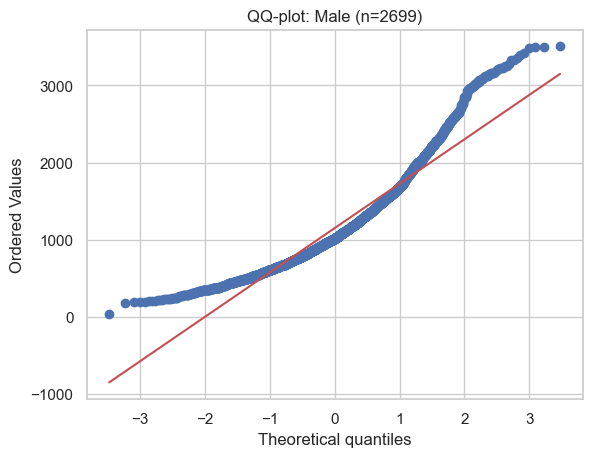

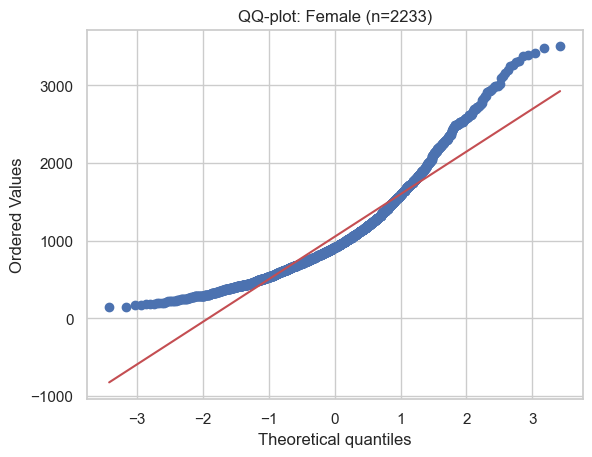

Shapiro–Wilk (Male): W=0.9327, p=3.216e-14 (tested n=500)
Shapiro–Wilk (Female): W=0.9103, p=1.303e-16 (tested n=500)
Brown–Forsythe variance test: W=4.3886, p=0.03623

=== TWO-GROUP RESULT ===
Test: Welch’s t-test (unequal variances robust)
t=6.0296, p=1.766e-09 | mean diff (Male-Female)=101.18 (95% CI 68.28, 134.08); df≈4826.5
Effect sizes: Cohen’s d=0.172, Hedges’ g=0.172
Male: n=2699, mean=1151.45, median=1016.26, sd=600.42
Female: n=2233, mean=1050.27, median=912.82, sd=574.90
Normal-ish? Yes  |  Variances similar? No  |  Balanced sizes? Yes
Notes: Prefer Welch by default; Student only when equal-variance & balanced design are credible. Use Mann–Whitney for strong non-normality/outliers.


In [384]:
# Two groups (LEDD by sex)
x = df_clean.loc[df_clean["sex"]=="Male",   "LEDD"]
y = df_clean.loc[df_clean["sex"]=="Female", "LEDD"]
compare_two_groups(x, y, label_x="Male", label_y="Female")



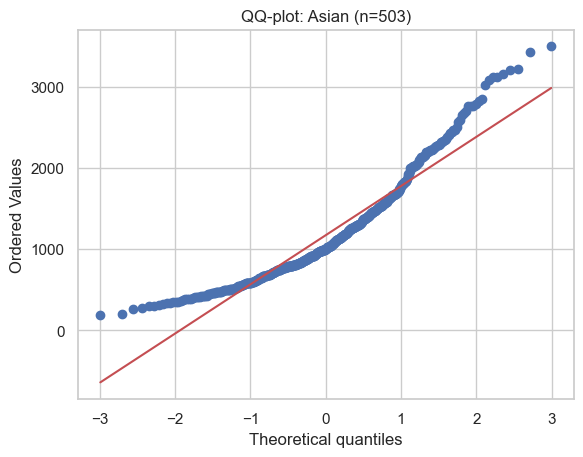

Shapiro–Wilk (Asian): W=0.9157, p=4.501e-16 (tested n=500)


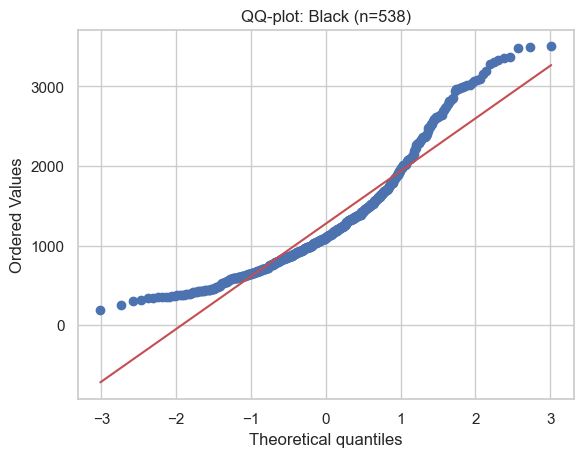

Shapiro–Wilk (Black): W=0.9128, p=2.273e-16 (tested n=500)


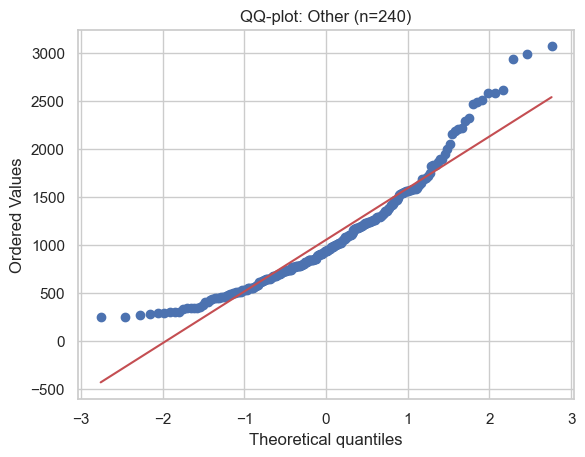

Shapiro–Wilk (Other): W=0.9188, p=3.611e-10 (tested n=240)


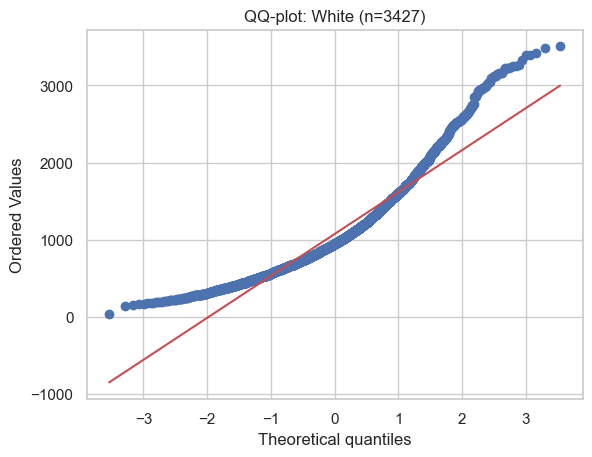

Shapiro–Wilk (White): W=0.9115, p=1.698e-16 (tested n=500)
Brown–Forsythe variance test: W=9.4334, p=3.268e-06

=== K-GROUP RESULT ===
Test: Kruskal–Wallis (rank-based omnibus)
H(3) = 45.1673, p = 8.525e-10
Effect size: ε² = 0.009  (often small with large N)
Group sizes: {'Asian': 503, 'Black': 538, 'Other': 240, 'White': 3427}
Means: {'Asian': 1170.76, 'Black': 1274.16, 'Other': 1053.17, 'White': 1075.33}
Medians: {'Asian': 1000.85, 'Black': 1101.06, 'Other': 933.42, 'White': 947.78}
Variances similar? No  |  Normal-ish? Yes
Post-hoc tip: Dunn’s test (`scikit-posthocs`) or pairwise Mann–Whitney + BH.


In [385]:
# ≥3 groups (LEDD by ethnicity)
groups, labels = [], []
for lab, g in df_clean.groupby("ethnicity", dropna=False):
    if lab in ["", np.nan]:  # optional: skip missing/blank
        continue
    groups.append(g["LEDD"])
    labels.append(str(lab))
compare_k_groups(groups, labels)

### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

Perform the same analysis for UPDRS part III scores! 
    1) Perform it for 60+ vs <60 age groups 
    2) Perform it for different BMI categories (e.g., underweight, normal weight, overweight, obese)


In [ ]:
# Write your code here

### 📝 Final reminder on how to report the results in the write-up or presentations


**Always state** what you tested, which test, statistic, p-value. Ideally, we would want to also report degrees of freedom (df) and an effect/estimate with uncertainty (e.g. confidence interval). Let's break these advanced concepts down:


**One-sentence templates**

* *Welch’s t-test:* “LEDD differed by sex, Welch’s *t*(df≈…)=…, **p**=…, **mean diff**=… mg, **95% CI** […, …].”
* *Student’s t-test:* same, but verify **equal variances** & **balanced sizes**.
* *Mann–Whitney U:* “LEDD distributions differed by sex, **U**=…, **p**=…, **median diff (HL)**=… mg, **95% CI** […, …].”
* *One-way ANOVA:* “LEDD differed across ethnicities, **F**(k−1, N−k)=…, **p**=…, **η²**=…; report group means.”
* *Kruskal–Wallis:* “LEDD distributions differed across ethnicities, **H**(k−1)=…, **p**=…, **ε²**=…; report group medians; Dunn post-hoc if needed.”

> If you want code: we already provide `mean_diff_CI(...)` in the notebook helpers to compute **Welch/Student CIs** for mean differences.

> Add a brief assumptions line if helpful (e.g., “QQ-plots roughly linear; Brown–Forsythe p=0.21 → variances similar.”)



# 🔗 Correlations

Correlation is another important statistical tool that helps us understand the relationship between two continuous variables, or **how variables change together**.

For example, imagine we want to understand if there's an association between eating chocolate and academic achievement. We could measure the average amount of chocolate consumed in any given country vs the number of Nobel laureates produced by that country. If we find that countries that consume more chocolate also tend to produce more Nobel laureates, we might say there's a positive correlation between chocolate consumption and academic achievement:

![Chocolate vs Nobel Laureates](https://dectech.co.uk/wp-content/uploads/2016/03/Capture.png)
> Taken from Maurage, P., Heeren, A., & Pesenti, M. (2013). Does Chocolate Consumption Really Boost Nobel Award Chances? The Peril of Over-Interpreting Correlations in Health Studies. The Journal of Nutrition, 143, 931-933

The correlations can also be negative - for example, let's say we want to hypothesise that higher ~~number of nights out~~ absences from lectures is associated with lower academic performance:
![Absences vs Grades](https://i0.wp.com/jonathanferrari.com/wp-content/uploads/2022/01/Number-of-Period-Absences-vs.-Total-GPA-1.png?w=744&ssl=1)
> Taken from Ferrari, J. R. (2022). You Snooze You Lose: A Correlational Study of GPA and Number of Absences. https://jonathanferrari.com/projects/snooze/
As you can see from the plot above, it is indeed the case (interpret it as you wish!).


### Correlation does not imply causation!!!
It's important to remember that **correlation does not imply causation**. Just because two variables are correlated does not mean that one causes the other. There could be other factors at play, or it could be a coincidence.


> A famous example is the correlation between ice cream sales and drowning incidents. Have a look at this picture: 
![Ice Cream vs Drowning](https://scontent-lhr6-2.xx.fbcdn.net/v/t1.6435-9/131145130_1304381033268271_4503853493613279290_n.png?_nc_cat=105&ccb=1-7&_nc_sid=127cfc&_nc_ohc=Mf5ZCpoObUQQ7kNvwF4C_AL&_nc_oc=AdmSKdzUofycBL8i3KPOKf0JBbS7vwnCaBazI54PCvhQh3U-V1SJZ5ovtYnbWxReacg&_nc_zt=23&_nc_ht=scontent-lhr6-2.xx&_nc_gid=yqfSSnmjmFM3TZ2F5diObw&oh=00_AfdsmB_B7H2JY2tSQM6GVjedGoAYfp_BJgfzDyBS-q0v0Q&oe=691987D2)


> At the first look, it seems that the relationship is clear! However, when we dig deeper, we can notice that both ice cream sales and drowning incidents tend to increase during the summer months. This suggests that there may be a lurking variable at play, that drives the causal change in both variables observed - hot weather. Warm summer month leads to more people swimming (and potentially drowning) and also more people buying ice cream.

> Unfortunately, the chocolate example above also falls into this category. Eating chocolate does not cause people to win Nobel prizes! When the scientists investigated further, they found that other factors drive both chocolate consumption and Nobel laureates, such as a country's wealth and investment in education and research. 

> As such, In formal terms, A (Nobel Prizes) correlates with B (chocolate) because both A and B are caused by C (wealth).  So eating more chocolate won’t increase your chances of winning a Nobel Prize and vice versa. 



### Statistical meaning of correlation

Correlation quantifies the **strength and direction** of a linear relationship between two continuous variables. 

* **Direction:** positive (>0) means they rise together; negative (<0) means one rises as the other falls; ≈0 means *no linear/monotonic* trend.
* **Strength (|r|):** the **magnitude** of the association, not its importance. Context matters. As a (very rough) rule of thumb people sometimes use: ~0.1 (small), ~0.3 (moderate), ~0.5 (large)—but a “small” r can matter in big datasets and a “large” r can be trivial if it’s spurious. Prefer domain context over fixed cutoffs.
* **r²:** proportion of variance explained by a *linear* relationship (Pearson only). E.g., r = 0.4 ⇒ r² = 0.16 (~16% of variance explained).

**What correlation is *not*:**

* **Causation.**
     > **Confounders** (hidden variables that drive the relationship, wealth of the country in the Nobel Prize Laureates vs Chocolate Consumption example), **reverse causation** (e.g., depression causing pain rather than the other way around), **seasonal effects** (e.g., ice cream sales rising in summer while drowning incidents also increase), and **range restriction** (e.g., only studying a specific age group) can fool you!
* A guarantee of **linearity** (Spearman/Kendall capture monotonic trends that needn’t be straight lines).
* Immune to **outliers** (Pearson is particularly sensitive).



### 🧪 The hypothesis test behind correlation

* **Null (H₀):** population correlation = 0 (no association).
* **p-value:** probability of seeing an r **at least as extreme** as observed if H₀ were true. A small p (<0.05) suggests evidence against H₀—but **doesn’t** tell you the effect size or the probability H₀ is true.
* **Confidence interval (CI):** the range of plausible population correlations given your sample. Prefer reporting **r with a 95% CI** over p alone.



## 🧰 Choosing the appropriate correlation method (zero-jargon version)

### Mini-glossary of terms used below

* **Linear:** the cloud of points can be summarized by a **straight** line.
* **Monotonic:** as X increases, Y **tends to** only go up (or only go down) overall—curve allowed, just no big reversals.

    ![Linear vs Monotonic](https://www.statisticshowto.com/wp-content/uploads/2018/11/monotonic-relationship.png)
* **Equal spread (a.k.a. homoscedastic):** the **vertical scatter** of Y looks **similar** across the range of X (not tight on the left and very wide on the right). 
* **Heteroscedastic:** the vertical spread of Y **changes** across X.
    ![Homoscedastic vs Heteroscedastic](https://wallstreetmojo-files.s3.ap-south-1.amazonaws.com/2022/08/Picture16.png)

* **Ordinal:** values that have a **natural order** (e.g., mild < moderate < severe), even if the gaps between levels aren’t equal.
* **Ties:** **identical values** after ranking (common with rounded or discrete data—for example, many patients having the **same** whole-number score).
* **Concordant/discordant pairs (Kendall idea):** look at **pairs of observations**—if both go up together (or down together) they’re **concordant**; if one goes up while the other goes down, **discordant**. 
    > For example, let's say we have two observations of two variables X, Y. One observation is (x1, y1), whilst the other observation is (x2, y2). If x2 > x1 and y2 > y1, then the pair is concordant. If x2 > x1 but y2 < y1, then the pair is discordant. So for the pairs (2,3) and (4,5) are concordant (both go up), while (2,5) and (4,3) are discordant (one goes up, the other down).

    ![](https://www.researchgate.net/profile/Jan-Rademaker/publication/12557294/figure/fig4/AS:670535092551681@1536879432135/Concordant-and-discordant-pairs-of-similarity-values-for-explanation-see-text.png)





### Which correlation should I use?

| Method            | Use when…                                                                                                                                            | What it captures                                                | Why it’s good                                                     | Be careful when…                                                                |
| ----------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **Pearson (r)**   | Both variables are numbers; the relationship looks **roughly straight-line**; there aren’t big outliers; the vertical **spread is similar** across X | **Straight-line** association                                   | Familiar; fast; you can report **r²** (“% of variance explained”) | It can be **pulled** by outliers or **miss** curved patterns                    |
| **Spearman (ρ)**  | Variables are numerical **or ordered**; relationship is **monotonic** (always trending up or down), even if **curved**; some outliers are ok         | **Rank-based** monotonic association                            | Robust to outliers; works when the shape isn’t straight-line      | If there are **lots of identical values (ties)**, it can be a bit less decisive |
| **Kendall (τ-b)** | Same situations as Spearman; especially good with **many identical values** or **small samples**                                                     | Agreement of **pairwise directions** (concordant vs discordant) | Interpretable with ties; behaves well in **small n**              | Often a bit **less power** than Spearman for the same n                         |

**Quick rule of thumb**

1. Plot a scatter first. Looks **straight-line** and clean → **Pearson**.
2. Looks **curved but consistently up/down**, or you see **outliers** or **ordered categories** → **Spearman** (or **Kendall τ-b** if you have many identical values).
3. Need the association **while holding other variables constant** → use **partial correlation** or a **regression model**.



### 📊 Scatter plots with annotated r, p and CI


In [389]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, norm


def pearson_ci(r, n, alpha=0.05):
    """Fisher z CI for Pearson r."""
    if n <= 3 or np.isclose(abs(r), 1):
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    zcrit = norm.ppf(1 - alpha/2)
    lo, hi = z - zcrit*se, z + zcrit*se
    return tuple(np.tanh([lo, hi]))

def corr_stat(x, y, method="pearson"):
    mask = x.notna() & y.notna()
    x, y = x[mask].astype(float), y[mask].astype(float)
    n = len(x)
    if n < 3:
        return np.nan, np.nan, n, (np.nan, np.nan)
    if method=="pearson":
        r, p = pearsonr(x, y)
        lo, hi = pearson_ci(r, n)
    elif method=="spearman":
        r, p = spearmanr(x, y)
        lo, hi = (np.nan, np.nan)  # CI optional via bootstrap (see below)
    elif method=="kendall":
        r, p = kendalltau(x, y)
        lo, hi = (np.nan, np.nan)
    else:
        raise ValueError("method must be 'pearson', 'spearman', or 'kendall'")
    return r, p, n, (lo, hi)

def annotate_corr(ax, data, x, y, method="pearson", loc=0.02, yloc=0.98):
    r, p, n, (lo, hi) = corr_stat(data[x], data[y], method)
    if np.isnan(r): 
        text = "n<3"
    else:
        ptxt = f"p={p:.3g}" if p>=0.001 else "p<0.001"
        if method=="pearson" and not np.isnan(lo):
            text = f"{method.title()} r={r:.2f} [{lo:.2f}, {hi:.2f}], {ptxt}, n={n}"
        else:
            text = f"{method.title()} r={r:.2f}, {ptxt}, n={n}"
    ax.text(loc, yloc, text, transform=ax.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))


### Example 1 - Pearson correlation between Years Since Diagnosis and UPDRS part III scores

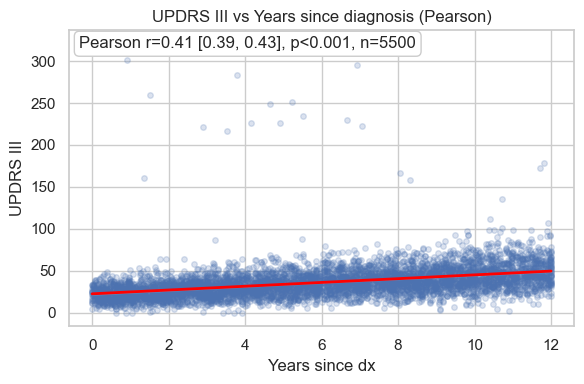

In [390]:
d = df[["years_since_dx","updrs_iii"]].dropna()

fig, ax = plt.subplots(figsize=(6,4))
sns.regplot(data=d, x="years_since_dx", y="updrs_iii",
            scatter_kws={"alpha":0.2, "s":16, "edgecolor":None},
            line_kws={"lw":2, "color": "red"}, ci=95, ax=ax)
annotate_corr(ax, d, "years_since_dx", "updrs_iii", method="pearson")
ax.set(title="UPDRS III vs Years since diagnosis (Pearson)", xlabel="Years since dx", ylabel="UPDRS III")
plt.tight_layout()
plt.show()

As you can see, there is a moderate positive correlation between Age and UPDRS part III scores (r = 0.48, p < 0.001), indicating that as age increases, UPDRS part III scores tend to increase as well. The 95% confidence interval for the correlation coefficient ranges from 0.46 to 0.50.

However, can you see the **outliers in the top right corner**? These points may be influencing the correlation coefficient. Let's see what happens if we use Spearman's rank correlation instead.

### Example 2 — Spearman (monotonic, non-linear allowed)

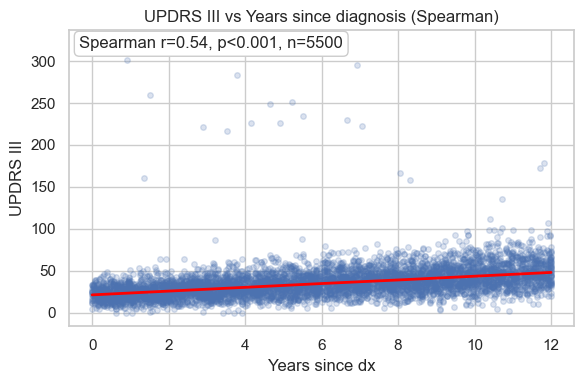

In [391]:

fig, ax = plt.subplots(figsize=(6,4))
sns.regplot(data=d, x="years_since_dx", y="updrs_iii",
            lowess=True,  # smoother captures monotonic curves
            scatter_kws={"alpha":0.2, "s":16, "edgecolor":None},
            line_kws={"lw":2, "color": "red"}, ci=95, ax=ax)
annotate_corr(ax, d, "years_since_dx", "updrs_iii", method="spearman")
ax.set(title="UPDRS III vs Years since diagnosis (Spearman)", xlabel="Years since dx", ylabel="UPDRS III")
plt.tight_layout()
plt.show()


We have a higher strength of association (ρ = 0.058) compared to Pearson's r (0.48), suggesting a stronger monotonic relationship between Age and UPDRS part III scores when considering the ranks of the data. This is due to Spearman's robustness to the outliers. The p-value remains significant (< 0.001), indicating that this association is unlikely to be due to chance. 

### Let's calculate both Pearson, Spearman and Kendallcorrelation coefficients for cleaned and uncleaned datasets!

As we mentioned earlier, the outliers in UPDRS III results from the data entry errors. Let's remove implausible values (e.g., UPDRS III > 132, which is the max score) and see how the correlation coefficients change.

In [392]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def corr_all(x, y):
    out = {}
    for name, fn in [("Pearson", pearsonr), ("Spearman", spearmanr), ("Kendall", kendalltau)]:
        r, p = fn(x, y)
        out[name] = (float(r), float(p), len(x))
    return out

# Full data
full = d.copy()

# Remove implausible UPDRS III values 
max_updrs = 132
trim = d[(d["updrs_iii"] <= max_updrs)]

def summarize(label, data):
    out = corr_all(data["years_since_dx"], data["updrs_iii"])
    print(f"{label}: n={len(data)}")
    for k,(r,p,n) in out.items():
        ptxt = f"p={p:.3g}" if p>=0.001 else "p<0.001"
        print(f"  {k:<8} r={r:.3f}  {ptxt}")
    print()

summarize("Full", full)
summarize("Trimmed implausible values", trim)


Full: n=5500
  Pearson  r=0.408  p<0.001
  Spearman r=0.536  p<0.001
  Kendall  r=0.372  p<0.001

Trimmed implausible values: n=5480
  Pearson  r=0.534  p<0.001
  Spearman r=0.540  p<0.001
  Kendall  r=0.375  p<0.001



### What if we have a smaller sample size?

Now, let's sample a smaller subset of the data to see how Kendall's tau-b performs with a smaller sample size in comparison with the other 2 methods!

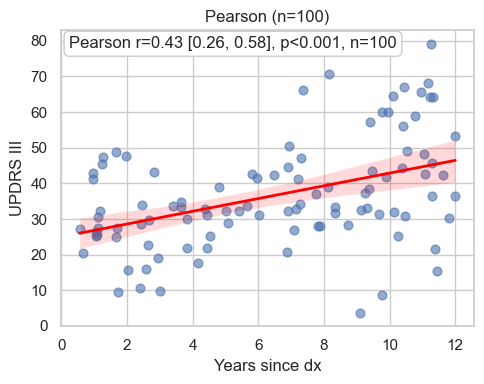

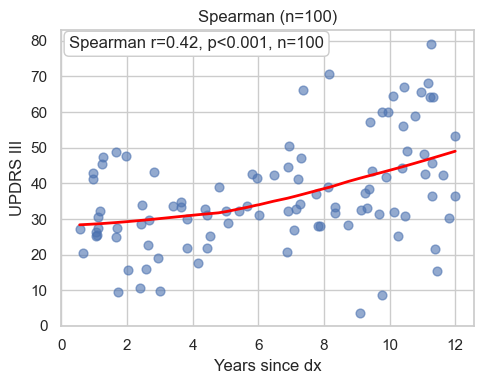

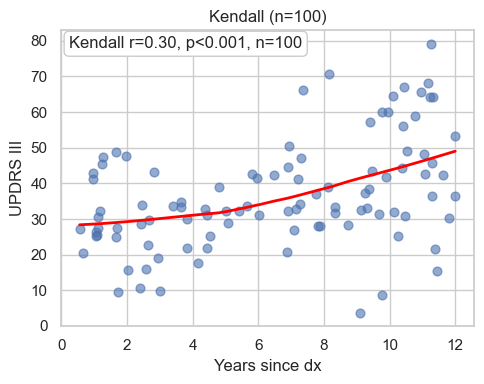

In [393]:
rng = np.random.default_rng(2025)
rows = rng.choice(d.index, size=100, replace=False)
d_sub = d.loc[rows].copy()
# remove implausible UPDRS III values
#d_sub = d_sub[d_sub["updrs_iii"] <= max_updrs]

for method in ["pearson","spearman","kendall"]:
    fig, ax = plt.subplots(figsize=(5,4))
    sns.regplot(
        data=d_sub, x="years_since_dx", y="updrs_iii",
        lowess=(method!="pearson"),
        scatter_kws={"alpha":0.6, "s":40, "edgecolor":None},
        line_kws={"lw":2, 'color': 'red'}, ci=95, ax=ax
    )
    annotate_corr(ax, d_sub, "years_since_dx", "updrs_iii", method=method)
    ax.set(title=f"{method.title()} (n=100)", xlabel="Years since dx", ylabel="UPDRS III")
    plt.tight_layout()
    plt.show()


As you can see, even with a smaller sample size, Kendall's tau-b still provides a meaningful measure of association (τ = 0.41, p < 0.001), which remains stable despite the outliers and using just 100 samples out out 5000. Both hte Pearson and Spearman correlation coefficients have changed more noticeably with the smaller sample size and/or outliers, indicating that they may be more sensitive to sample size fluctuations in this case.

### Group linear trends
You can also examine correlations **within groups** (e.g., by sex, ethnicity).
This helps see if the relationship holds consistently or differs across subpopulations.

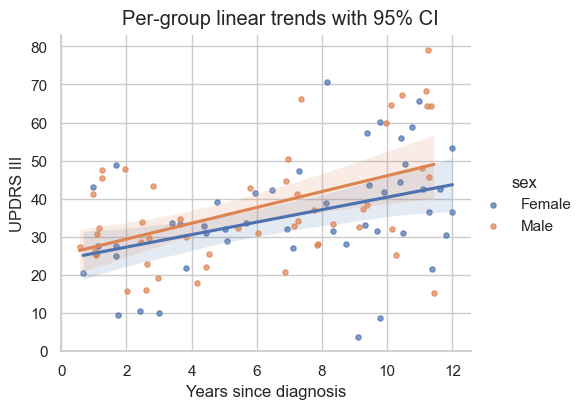

Kendall tau (Female): r=0.288, p=0.00348, n=49
Kendall tau (Male): r=0.302, p=0.00177, n=51


In [394]:
### Per-group linear trends (one line per group)

d = df[["years_since_dx","updrs_iii","sex"]].dropna()

# sample 100 points for clarity
rng = np.random.default_rng(2025)
rows = rng.choice(d.index, size=100, replace=False)
d = d.loc[rows].copy()

g = sns.lmplot(
    data=d, x="years_since_dx", y="updrs_iii",
    hue="sex", height=4, aspect=1.25,
    scatter_kws={"alpha":0.7, "s":14, "edgecolor":None},
    ci=95
)
g.set_axis_labels("Years since diagnosis", "UPDRS III")
g.fig.suptitle("Per-group linear trends with 95% CI", y=1.02)
plt.show()

# calcualte kendall tau per group
for sex, gdata in d.groupby("sex"):
    r, p = kendalltau(gdata["years_since_dx"], gdata["updrs_iii"])
    ptxt = f"p={p:.3g}" if p>=0.001 else "p<0.001"
    print(f"Kendall tau ({sex}): r={r:.3f}, {ptxt}, n={len(gdata)}")



## 🗺️ Correlation matrices + heatmaps 
We often want to see the correlation structure across **many variables** at once. A **correlation matrix** shows all pairwise correlations in a grid.

`pandas` and `seaborn` have built-in functions to compute and plot these matrices as **heatmaps**, where colors indicate strength/direction of the correlation.

### Example - Correlation matrix for numerical variables in our dataset



In [395]:
# Do a correlation matrix for the numeric vars in df_clean
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# do correlation matrix
df_numeric = df_clean[numeric_cols].copy()
corr_matrix = df_numeric.corr(method='spearman')
corr_matrix 


,years_since_dx,age,BMI,LEDD,updrs_iii
years_since_dx,1.000000,-0.001288,-0.000075,0.362043,0.536505
age,-0.001288,1.000000,0.006426,0.434447,0.344465
BMI,-0.000075,0.006426,1.000000,0.149250,0.095267
LEDD,0.362043,0.434447,0.149250,1.000000,0.382703
updrs_iii,0.536505,0.344465,0.095267,0.382703,1.000000


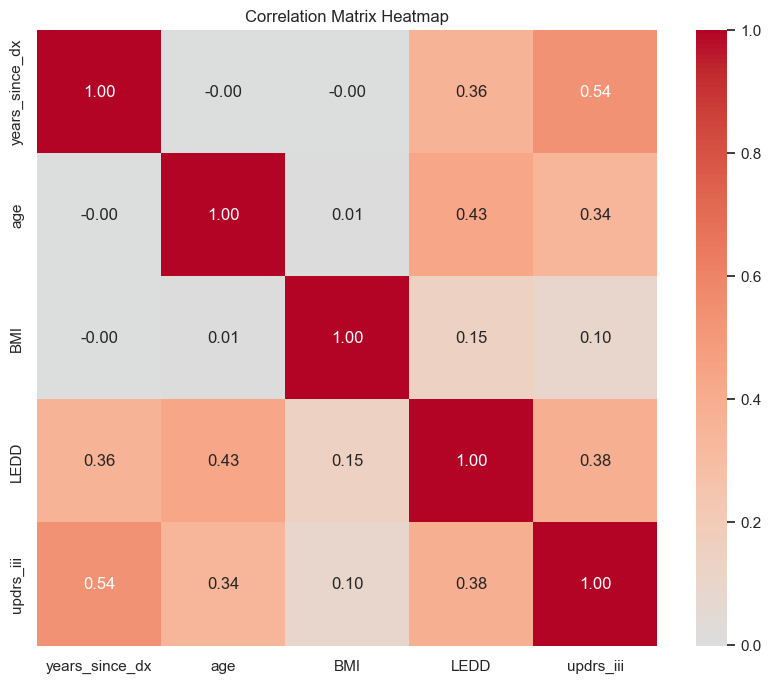

In [396]:
# Now let's show it as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()


However, ideally, we would also want to demonstrate the significance of the correlation through p-values. The function below computes r and p matrices for **Pearson/Spearman/Kendall**, handles pairwise missingness, and overlays `*`/`**`/`***` for p<.05/.01/.001. 

Data reduced from 5500 to 5000 rows after dropping duplicates.


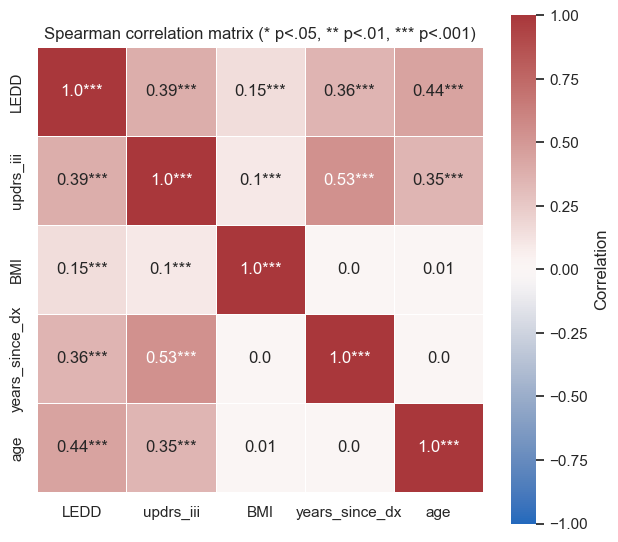

In [397]:

from itertools import product

def corr_p_mats(data, cols, method="pearson"):
    C = pd.DataFrame(index=cols, columns=cols, dtype=float)
    P = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for a, b in product(cols, cols):
        r, p, n, _ = corr_stat(data[a], data[b], method=method)
        C.loc[a, b] = r
        P.loc[a, b] = p
    return C.astype(float), P.astype(float)

def stars_from_p(p):
    if pd.isna(p): return ""
    return "***" if p<1e-3 else "**" if p<1e-2 else "*" if p<5e-2 else ""

# Before we compute correlations, we need to make sure we don't have any repeated measurements per subject.
# For this example, we'll just take the first measurement per subject (drop duplicates based on the pateint ID).

df_nodup = df.drop_duplicates(subset="patient_id", keep="first")
print(f"Data reduced from {len(df)} to {len(df_nodup)} rows after dropping duplicates.")


vars_num = ["LEDD","updrs_iii","BMI","years_since_dx","age"]
d = df_nodup[vars_num].copy()


# Spearman often a good default in messy real data
C, P = corr_p_mats(d, vars_num, method="spearman")
annot = C.round(2).astype(str)
for i in annot.index:
    for j in annot.columns:
        annot.loc[i,j] = annot.loc[i,j] + stars_from_p(P.loc[i,j])

plt.figure(figsize=(6.4,5.6))
sns.heatmap(C, vmin=-1, vmax=1, center=0, cmap="vlag", square=True,
            annot=annot, fmt="", linewidths=.5, cbar_kws={"label":"Correlation"})
plt.title("Spearman correlation matrix (* p<.05, ** p<.01, *** p<.001)")
plt.tight_layout()
plt.show()





###  Multiple comparisons - the sneaky issue


When you test many correlations at once, some will appear significant just by chance.

Remember the threshold we're checking the p-value against? It's called α (alpha), which the significance threshold you choose before looking at the data — your tolerated risk of a false positive in one hypothesis test. In our case, we set α=0.05.

When you run multiple tests, the chance of getting at least one false positive increases. Here’s how it scales:

* If you run **~10–20** pairwise tests, you’re already at **~0.5–1 expected false positive** at α=0.05
* With **45 tests** (just **10 variables** in a correlation matrix), you expect **~2.25 false positives** and the chance of **≥1 false positive is ~90%**.
* With **100 tests**, you expect **~5 false positives** and the chance of ≥1 is **>99%**.

So for correlation matrices, **We need to startusing FDR at ~8–10 variables (28–45 pairs)**, and absolutely use it beyond that.

### Why does multiplicity matter?

Let `m` be the number of tests. If all nulls were true:

* **Expected number of false positives ≈ α·m** (e.g., 0.05·m).
* **Probability of at least one false positive (FWER) ≈ 1 − (1 − α)^m**.

For a correlation matrix over `p` variables, the number of pairwise correlations is `m = p(p − 1)/2`. Here are some representative counts (α=0.05):

| Variables (p) | Pairs m = p(p−1)/2 | Expected false + (α·m) | P(≥1 false +) ≈ 1 − (0.95)^m |
| ------------: | -----------------: | ---------------------: | ---------------------------: |
|             5 |                 10 |                    0.5 |                          40% |
|             8 |                 28 |                    1.4 |                          76% |
|            10 |                 45 |                   2.25 |                          90% |
|            12 |                 66 |                    3.3 |                          96% |
|            15 |                105 |                   5.25 |                          99% |
|            20 |                190 |                    9.5 |                      >99.99% |
|            30 |                435 |                   21.8 |                        ~100% |
|            50 |               1225 |                   61.3 |                        ~100% |

*(These FWER numbers assume independence; real correlations between tests change them a bit, but the takeaway is the same: multiplicity bites fast.)*




## 2) Techniques to counteract this — Bonferroni and Benjamini–Hochberg


### The goals are different

* **Bonferroni** controls the **Family-Wise Error Rate (FWER)**: the chance of making **at least one** false positive across all tests.
* **Benjamini–Hochberg (BH)** controls the **False Discovery Rate (FDR)**: the expected **proportion** of false positives **among the results you call “significant.”**


### What does **Bonferroni** do?

* Controls **FWER** (probability of **any** false positive in the family).
    > “Family” = the set of tests you’re adjusting together (e.g., all pairwise correlations you’ll report); “any false positive” = **at least one** spurious significant result **anywhere in that set**. 
* **Strict (very conservative)**: declare significant if:
    * $p_i \le \alpha/m $, where $\alpha$ is the significance threshold,  $m$ is the number of tests 
    * or use adjusted $p_i^{adj}=\min(p_i\cdot m,1) $ 
* Good for **a few pre-specified** hypotheses; but can be **too conservative** for large correlation matrices.

### What does **Benjamini–Hochberg (BH)** do?

* Controls **FDR** (expected **proportion** of false positives among your discoveries).
* **More powerful** than Bonferroni when testing many pairs.
* Assumes independence or **positive dependence** (typical for correlation scans).
* Procedure
    1. Sort the m p-values: $p_{(1)} \le \dots \le p_{(m)}$.
    2. Compute thresholds $t_k = \frac{k}{m}\alpha$ for $k=1,\dots,m$.
    3. **k = max** index with $p_{(k)} \le t_k$.
    4. Reject (call significant) the hypotheses with ranks $1,\dots,k$.
    * If none satisfy it → **k = 0** (no discoveries).
    * If all satisfy it → **k = m**.


* **Tiny example (m=10, α=0.05):**
    * Sorted p’s = [0.001, 0.006, 0.012, 0.022, 0.041, …]
    * Thresholds $t_k = 0.005k$ ⇒ [0.005, 0.010, 0.015, 0.020, 0.025, …]
    * $0.001 \le 0.005$ ✓
    * $0.006 \le 0.010$ ✓
    * $0.012 \le 0.015$ ✓
    * $0.022 \le 0.020$ ✗ → **k = 3**, so the first **3** tests are significant.




| Method                      | What it controls                          | Typical use                                                                       | Pros                                                  | Cons                                                                    |
| --------------------------- | ----------------------------------------- | --------------------------------------------------------------------------------- | ----------------------------------------------------- | ----------------------------------------------------------------------- |
| **Bonferroni**              | **FWER** (prob ≥1 false positive)         | Few pre-specified hypotheses; confirmatory analyses; clinical primary endpoints   | Very simple; very strict                              | Can be **over-conservative**; lower power, especially when (m) is large |
| **BH (Benjamini–Hochberg)** | **FDR** (proportion of false discoveries) | Many tests (omics, full correlation matrices, feature scans), exploratory screens | **More power**; widely accepted default for large (m) | You accept that a small fraction of calls may be false                  |

### Examples with different number of pairwise comparisons (α = 0.05)

* **Bonferroni** with (m=45) tests → threshold (0.05/45 \approx 0.0011).

* **BH** with (m=45) → the cutoff **rises** with rank (k): 
    * (k=5) ⇒ $0.05\cdot 5/45 \approx 0.0056$; 
    * (k=10) ⇒ $0.05\cdot 10/45 \approx 0.011$, etc. 

* This “step-up” is why BH is more powerful.



### Code: apply **both** corrections on a correlation matrix


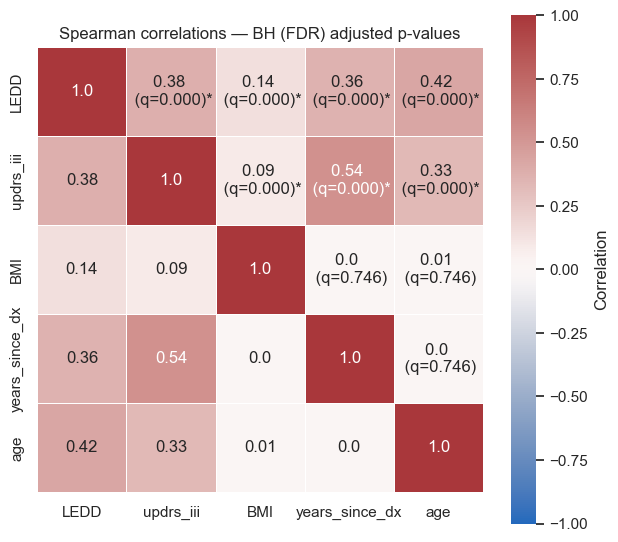

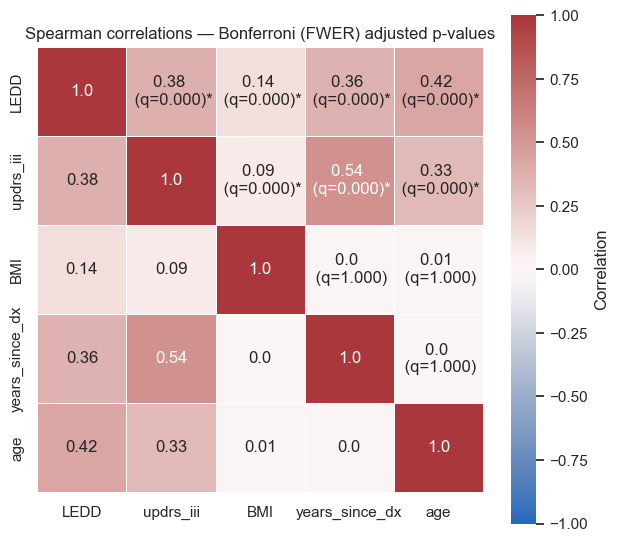

In [398]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.stats.multitest import multipletests

sns.set_theme(style="whitegrid", context="notebook")

def corr_p_mats(data: pd.DataFrame, cols, method="spearman"):
    """Return correlation (C) and p-value (P) matrices with pairwise deletion."""
    C = pd.DataFrame(index=cols, columns=cols, dtype=float)
    P = pd.DataFrame(index=cols, columns=cols, dtype=float)
    fn = {"pearson": pearsonr, "spearman": spearmanr, "kendall": kendalltau}[method]
    for i in cols:
        for j in cols:
            x = data[i]; y = data[j]
            mask = x.notna() & y.notna()
            if mask.sum() < 3:
                C.loc[i,j] = np.nan; P.loc[i,j] = np.nan
            else:
                r, p = fn(x[mask], y[mask])
                C.loc[i,j] = float(r); P.loc[i,j] = float(p)
    return C, P

def adjust_pvals_matrix(P: pd.DataFrame, method="fdr_bh"):
    """
    Adjust only the unique tests (upper triangle, no diagonal) and mirror back.
    Returns (Q, q_series) where Q is a full matrix of adjusted p/q and q_series is the 1D upper-tri series.
    """
    mask_ut = pd.DataFrame(np.triu(np.ones_like(P, bool), k=1), index=P.index, columns=P.columns)
    p_ut = P.where(mask_ut).stack()  # Series indexed by (row, col)
    if p_ut.empty:
        raise ValueError("No pairwise p-values found to adjust.")
    _, qvals, _, _ = multipletests(p_ut.values, method=method)
    q_series = pd.Series(qvals, index=p_ut.index)

    Q = pd.DataFrame(np.nan, index=P.index, columns=P.columns)
    for (i, j), q in q_series.items():
        Q.loc[i, j] = q
        Q.loc[j, i] = q  # mirror for convenience
    np.fill_diagonal(Q.values, 0.0)  # optional: set self to 0
    return Q, q_series

def heatmap_with_q(C, P, method="fdr_bh", alpha=0.05, title=None):
    """Annotate each upper-tri cell with r and adjusted q (or Bonferroni-adjusted p)."""
    Q, q_series = adjust_pvals_matrix(P, method=method)
    annot = C.round(2).astype(str)

    for (i, j), q in q_series.items():
        star = "*" if q < alpha else ""
        annot.loc[i, j] = f"{annot.loc[i, j]} \n (q={q:.3f}){star}"

    plt.figure(figsize=(6.4,5.6))
    sns.heatmap(C, vmin=-1, vmax=1, center=0, cmap="vlag", square=True,
                annot=annot, fmt="", linewidths=.5, cbar_kws={"label":"Correlation"})
    plt.title(title or f"Correlation matrix with {method.upper()} adjusted p-values (α={alpha})")
    plt.tight_layout()
    plt.show()

# === Choose variables and build matrices (Spearman is robust for messy data) ===
vars_num = ["LEDD","updrs_iii","BMI","years_since_dx","age"]  # adjust to your columns
C, P = corr_p_mats(df, vars_num, method="spearman")

# === Benjamini–Hochberg (FDR) view ===
heatmap_with_q(C, P, method="fdr_bh", alpha=0.05,
               title="Spearman correlations — BH (FDR) adjusted p-values")

# === Bonferroni (FWER) view ===
heatmap_with_q(C, P, method="bonferroni", alpha=0.05,
               title="Spearman correlations — Bonferroni (FWER) adjusted p-values")


**How to read the plots**

* Each annotated upper-triangle cell shows: **correlation** and **adjusted p** (called **q** in the label).
* Compare the adjusted value to **α** (e.g., 0.05). Expect **fewer** significant pairs under **Bonferroni** than under **BH**.
* Always report the **effect size** (correlation) with a **95% CI**, not just q/p.

> If you want an FWER method that’s uniformly more powerful than Bonferroni while remaining strict, try `method="holm"` (Holm step-down).




## 🧭 Good practice checklist

* **Plot first.** Look for nonlinearity, outliers, and subgroups (color by `sex` etc.).
* **Report**: method used, r (and **95% CI**), p, n, and any adjustments (e.g., FDR).
* **Handle missingness** explicitly (all examples above use **pairwise** deletion).
* **Beware confounding** (age, disease duration…). Use **partial correlations** or regression.
* **Multiple testing**: adjust if you scan many pairs (heatmaps).
* **Repeated measures?** Standard correlations assume **independent** observations. If you have multiple visits per patient, use **repeated-measures correlation** or a **mixed-effects** model.





### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

1. Using the dataset provided, calculate the Pearson, Spearman, and Kendall correlation coefficients between age and LEDD. Plot the scatterplots with regression lines for each method. Report the correlation coefficients, p-values, and 95% confidence intervals for each method. Discuss any differences you observe among the three methods.
2. Create a correlation matrix for all numerical variables in the dataset using Kendall's correlation. Apply the Benjamini-Hochberg correction for multiple comparisons and identify which correlations remain significant at an alpha level of 0.05. Visualize the correlation matrix as a heatmap, annotating significant correlations.

In [ ]:
# Write your code here

## 📈More ways to visualise trend in the data

###   Mean Trend with Shaded 95% CI (seaborn.lineplot)

`lineplot` summarizes y for each x and draws intervals. 

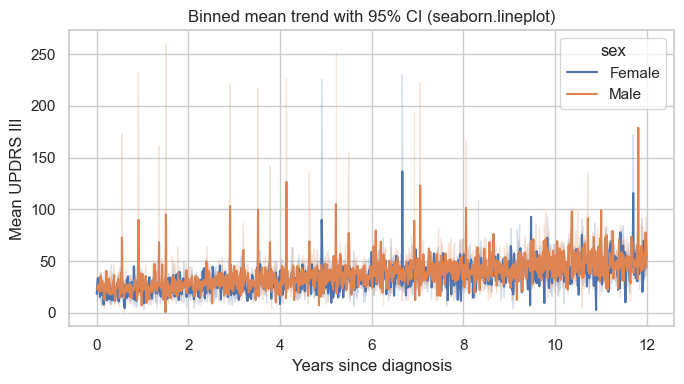

In [401]:

d = df[["years_since_dx","updrs_iii","sex"]].dropna().copy()


plt.figure(figsize=(7,4))
sns.lineplot(
    data=d,
    x="years_since_dx", y="updrs_iii", hue="sex",
    estimator="mean",
    errorbar=("ci", 95),  # use ci=95 if seaborn<0.12
    n_boot=500
)

plt.xlabel("Years since diagnosis")
plt.ylabel("Mean UPDRS III")
plt.title("Binned mean trend with 95% CI (seaborn.lineplot)")
plt.tight_layout()
plt.show()


For continuous x, this works best if x has repeated or binned values. We’ll **bin x** to make a clean mean-trend with CIs. This helps to see overall patterns without being distracted by noise.

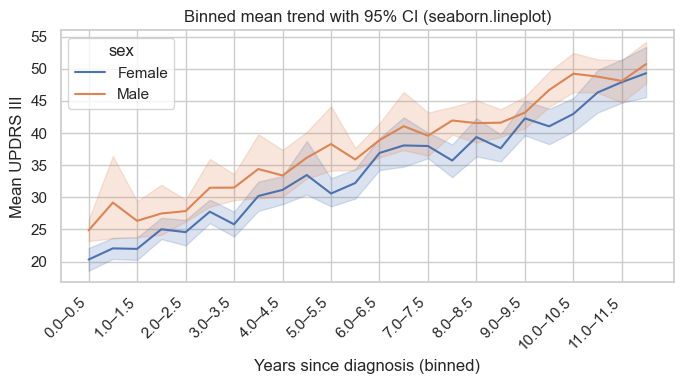

In [402]:
# Prep data
d = df[["years_since_dx","updrs_iii","sex"]].dropna().copy()

bin_width = 0.5
bins = np.arange(0, d["years_since_dx"].max() + bin_width, bin_width)
cats = pd.IntervalIndex.from_breaks(bins)

# Bin and map to midpoints robustly (no NaNs)
d["xbin"] = pd.cut(d["years_since_dx"], bins=cats, include_lowest=True)
mid_by_cat = pd.Series([iv.mid for iv in cats], index=cats)
d["x_mid"] = d["xbin"].map(mid_by_cat)        # safe mapping via categories, not lambda

# Nice tick labels (skip NaNs)
mids = np.sort(d["x_mid"].dropna().unique())
tick_mids   = mids[::max(1, len(mids)//12)]
tick_labels = [f"{m - bin_width/2:.1f}–{m + bin_width/2:.1f}" for m in tick_mids]

plt.figure(figsize=(7,4))
sns.lineplot(
    data=d,
    x="x_mid", y="updrs_iii", hue="sex",
    estimator="mean",
    errorbar=("ci", 95),   # or ci=95 if seaborn<0.12
    n_boot=500
)
plt.xticks(tick_mids, tick_labels, rotation=45, ha="right")
plt.xlabel("Years since diagnosis (binned)")
plt.ylabel("Mean UPDRS III")
plt.title("Binned mean trend with 95% CI (seaborn.lineplot)")
plt.tight_layout()
plt.show()


### 🛠️ Binned Means + Error Bars
Sometimes you want full control. Here we compute **mean ± 95% CI** per x-bin and plot **points + error bars**, plus a **shaded band**.

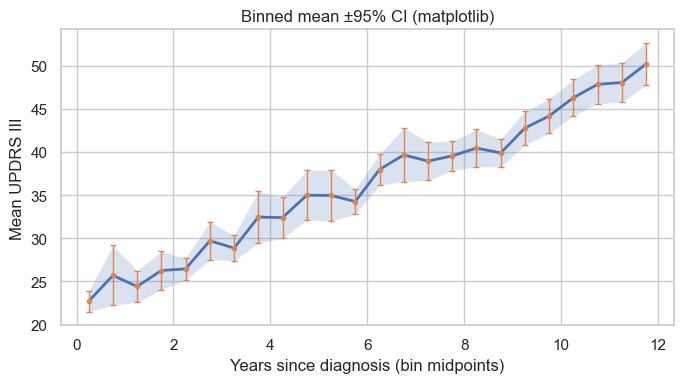

In [403]:
from scipy.stats import t

def binned_summary(df_, x, y, bin_width=0.5):
    d = df_[[x, y]].dropna().copy()
    bins = np.arange(0, d[x].max() + bin_width, bin_width)
    d["bin"] = pd.cut(d[x], bins=bins, include_lowest=True)
    g = d.groupby("bin", observed=True)
    out = pd.DataFrame({
        "x_mid": [iv.mid for iv in g.size().index],
        "n": g[y].count(),
        "mean": g[y].mean(),
        "sd": g[y].std()
    }).dropna(subset=["mean"])
    out["se"] = out["sd"] / np.sqrt(out["n"].clip(lower=1))
    # Use t-quantile for 95% CI
    out["tcrit"] = t.ppf(0.975, df=(out["n"] - 1).clip(lower=1))
    out["ci"] = out["tcrit"] * out["se"]
    return out

d = df[["years_since_dx","updrs_iii"]].dropna()

summ = binned_summary(d, "years_since_dx", "updrs_iii", bin_width=0.5)

plt.figure(figsize=(7,4))
plt.plot(summ["x_mid"], summ["mean"], lw=2)
plt.fill_between(
    summ["x_mid"],
    summ["mean"] - summ["ci"],
    summ["mean"] + summ["ci"],
    alpha=0.2
)
plt.errorbar(
    summ["x_mid"], summ["mean"], yerr=summ["ci"],
    fmt="o", ms=3, lw=1, capsize=2
)
plt.xlabel("Years since diagnosis (bin midpoints)")
plt.ylabel("Mean UPDRS III")
plt.title("Binned mean ±95% CI (matplotlib)")
plt.tight_layout()
plt.show()

### Per-group binned trends (multiple lines + legends)

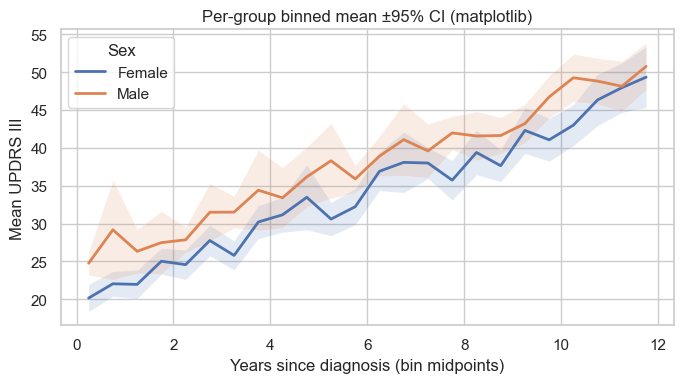

In [404]:
cols = ["years_since_dx","updrs_iii","sex"]
d = df[cols].dropna()

plt.figure(figsize=(7,4))
for name, gdf in d.groupby("sex"):
    summ = binned_summary(gdf, "years_since_dx", "updrs_iii", bin_width=0.5)
    plt.plot(summ["x_mid"], summ["mean"], lw=2, label=name)
    plt.fill_between(summ["x_mid"], summ["mean"]-summ["ci"], summ["mean"]+summ["ci"], alpha=0.15)
    #plt.errorbar(summ["x_mid"], summ["mean"], yerr=summ["ci"], fmt="o", ms=3, lw=1, capsize=2)

plt.xlabel("Years since diagnosis (bin midpoints)")
plt.ylabel("Mean UPDRS III")
plt.title("Per-group binned mean ±95% CI (matplotlib)")
plt.legend(title="Sex", frameon=True)
plt.tight_layout()
plt.show()

### 🚿 Dealing with Overplotting & Outliers

* Use **alpha < 0.4** and **small markers** (`s`).
* Try **binning** (as above) or **hexbin** for very dense plots. The colours of the hexagons represent point density (number of points in that area).

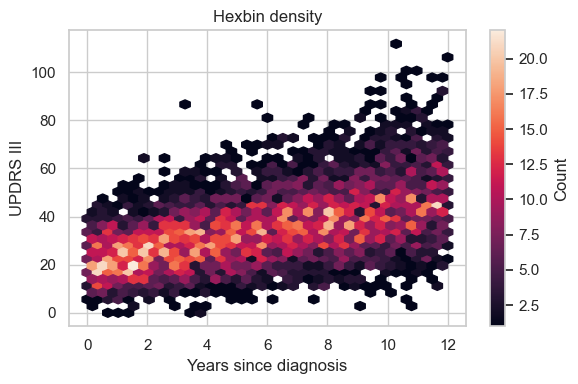

In [405]:
d = df_clean[["years_since_dx","updrs_iii"]].dropna()

plt.figure(figsize=(6,4))
hb = plt.hexbin(d["years_since_dx"], d["updrs_iii"], gridsize=35, mincnt=1)
plt.xlabel("Years since diagnosis")
plt.ylabel("UPDRS III")
plt.title("Hexbin density")
cb = plt.colorbar(hb)
cb.set_label("Count")
plt.tight_layout()
plt.show()

### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

1. Plot the mean LEDD against years since diagnosis using seaborn's `lineplot`, including shaded 95% confidence intervals and break it down according to the sex. Discuss the trend observed in the data.
2. Recreate the relationship between LEDD and age (from previous tasks) using hexbin plots to address overplotting. Comment on how this visualization compares to the scatter plots created earlier.


In [ ]:
# Write your code here

#### Advanced Material (optional) - Pairwise comparisons & multiple testing

When you have more than two groups and find a significant overall effect (e.g., via ANOVA or Kruskal–Wallis), you often want to know **which specific groups differ**. This requires **pairwise comparisons**.


* **After ANOVA:** use **Tukey’s HSD** or **Dunnett’s test** (if comparing to a control) for pairwise mean differences with adjusted p-values and CIs. Use **Games-Howell** if variances differ.

* **After Kruskal–Wallis:** use **Dunn’s test** with Bonferroni or Holm correction for pairwise median differences.

* **Adjust for multiple testing:** when doing many pairwise tests, control the family-wise error rate (FWER) or false discovery rate (FDR) using methods like Bonferroni, Holm, or Benjamini-Hochberg.


## What each test does 

* **Tukey’s HSD** (after ANOVA): all-pairs **mean** comparisons; controls family-wise error (FWER); assumes ~normality and **equal variances** (pooled).
* **Dunnett’s test** (after ANOVA): compares **each group vs a prespecified control**; FWER-controlled; same assumptions as Tukey.
  *Note:* there isn’t a widely used “one-liner” Dunnett in core Python stats libs; a practical alternative is **t-tests vs control + Holm** correction (FWER-controlled, slightly conservative vs exact Dunnett).
* **Games–Howell** (after ANOVA but **variances unequal** / unbalanced n): all-pairs **mean** comparisons using **Welch SEs** + Satterthwaite df; no equal-variance assumption.
* **Dunn’s test** (after Kruskal–Wallis): all-pairs **rank/median** comparisons; use **Bonferroni/Holm** for multiplicity.

> Rule of thumb: Homogeneous variances → **Tukey**; heteroscedastic or very unbalanced → **Games–Howell**; nonparametric ranks → **Dunn**. “Each vs control” → **Dunnett** (or t-tests + Holm).



## Tukey’s HSD (FWER (Family-Wise Error Rate)-controlled, equal variances)

In [345]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Example: LEDD by ethnicity
df_clean['ethnicity'] = df_clean['ethnicity'].replace('', np.nan)  # treat blank as NaN
dat = df_clean.dropna(subset=['LEDD', 'ethnicity']).copy()
tuk = pairwise_tukeyhsd(endog=dat['LEDD'].astype(float),
                        groups=dat['ethnicity'].astype(str),
                        alpha=0.05)

# Pretty table
tuk_tbl = pd.DataFrame(data=tuk._results_table.data[1:], columns=tuk._results_table.data[0])
tuk_tbl.rename(columns={'meandiff':'mean_diff','lower':'ci_low','upper':'ci_high','reject':'sig'}, inplace=True)
tuk_tbl

,group1,group2,mean_diff,p-adj,ci_low,ci_high,sig
0,Asian,Black,107.2284,0.0178,13.2237,201.2332,True
1,Asian,Other,-116.2473,0.0580,-235.1150,2.6204,False
2,Asian,White,-92.5488,0.0056,-164.8906,-20.2071,True
3,Black,Other,-223.4757,0.0000,-341.1172,-105.8343,True
4,Black,White,-199.7773,0.0000,-270.0860,-129.4685,True
5,Other,White,23.6985,0.9315,-77.4744,124.8713,False


> What you get: **pair**, **mean difference**, **95% CI**, adjusted **p**, and a boolean “reject” (significant).

### Dunnet's test (FWER-controlled, equal variances, vs control) from scipy

In [346]:
from scipy.stats import dunnett
import numpy as np
import pandas as pd

dat = df_clean.dropna(subset=['LEDD','ethnicity']).copy()

# Pick a control (example: most frequent level)
control = dat['ethnicity'].value_counts().idxmax()

# Build samples (every non-control group)
labels  = []
samples = []
for lab, g in dat.groupby('ethnicity'):
    if lab == control: 
        continue
    labels.append(lab)
    samples.append(g['LEDD'].dropna().astype(float).to_numpy())

control_group = dat.loc[dat['ethnicity'] == control, 'LEDD'].dropna().astype(float).to_numpy()

# 👇 KEY CHANGE: pass samples as *positional* args
res = dunnett(*samples, control=control_group, alternative="two-sided")

# Tidy output (Dunnett gives test stats & adjusted p-values; add raw mean diffs yourself)
ctrl_mean = control_group.mean()
mean_diffs = [np.mean(s) - ctrl_mean for s in samples]

dunnett_tbl = pd.DataFrame({
    "group_vs_control": labels,
    "mean_diff": mean_diffs,          # raw mean differences (add CIs via Welch+Holm if you need them)
    "statistic": res.statistic,       # Dunnett test statistic
    "p_adj": res.pvalue               # multiplicity-adjusted p-values vs control
}).sort_values("p_adj")
dunnett_tbl


,group_vs_control,mean_diff,statistic,p_adj
1,Black,199.777267,7.302341,9.903189e-13
0,Asian,92.548838,3.287813,3.045684e-03
2,Other,-23.698462,-0.601979,9.059427e-01


> Report: each group’s **mean vs control**, **95% CI**, **Holm-adjusted p**, and the **Welch/Student** method used.

## Games–Howell (heteroscedastic post-hoc)
Statsmodels' Tukey switches to Games–Howell when you pass `equal_var=False`.

In [408]:
import numpy as np, pandas as pd
from scipy.stats import tukey_hsd

# --- build per-group arrays, keep labels in the same order ---
dat = df_clean.dropna(subset=['LEDD','ethnicity']).copy()
gb      = list(dat.groupby('ethnicity', sort=False))
labels  = [name for name, _ in gb]
samples = [g['LEDD'].astype(float).to_numpy() for _, g in gb]

# --- run: Tukey (equal_var=True) or Games–Howell (equal_var=False) ---
res = tukey_hsd(*samples, equal_var=False)   # set to True for classic Tukey

# --- helper: flatten upper-triangle if a 2-D matrix is returned ---
def _flatten_pairwise(arr):
    a = np.asarray(arr)
    if a.ndim == 2:  # take upper triangle without diagonal
        iu = np.triu_indices_from(a, k=1)
        return a[iu]
    return a.ravel()

# --- build tidy DataFrame safely ---
ci = res.confidence_interval(0.95)

stat  = _flatten_pairwise(res.statistic)
pval  = _flatten_pairwise(res.pvalue)
ci_lo = _flatten_pairwise(ci.low)
ci_hi = _flatten_pairwise(ci.high)

pairs = [(labels[i], labels[j]) for i in range(len(labels)) for j in range(i+1, len(labels))]
assert len(pairs) == stat.size == pval.size == ci_lo.size == ci_hi.size, "length mismatch"

gh_df = pd.DataFrame({
    'group_a':  [a for a, b in pairs],
    'group_b':  [b for a, b in pairs],
    'mean_diff': stat,
    'ci_low':    ci_lo,
    'ci_high':   ci_hi,
    'p_adj':     pval
}).sort_values('p_adj')

gh_df


,group_a,group_b,mean_diff,ci_low,ci_high,p_adj
0,White,Black,-199.777267,-285.831396,-113.723139,4.027570e-09
6,Black,Other,223.475729,95.368909,351.582550,2.272079e-05
5,Black,,198.794798,69.887352,327.702245,2.759872e-04
1,White,Asian,-92.548838,-173.665958,-11.431718,1.610775e-02
4,Black,Asian,107.228429,-4.799685,219.256544,6.827816e-02
8,Asian,Other,116.247300,-8.617917,241.112517,8.179268e-02
7,Asian,,91.566369,-34.121792,217.254531,2.700822e-01
3,White,Other,23.698462,-78.671357,126.068281,9.691265e-01
9,,Other,24.680931,-115.441150,164.803012,9.889472e-01
2,White,,-0.982469,-104.373015,102.408077,9.999999e-01



> GH returns **adjusted p-values** for all pairs. If you also want pairwise **mean differences + CIs**, you can compute them via Welch SEs and studentized-range quantiles; happy to drop in a helper if you want that style.


## Dunn’s test (after Kruskal–Wallis)

In [409]:
import scikit_posthocs as sp
import pandas as pd
from scipy.stats import kruskal

dat = df_clean.dropna(subset=['LEDD','ethnicity']).copy()
groups = [g['LEDD'].to_numpy() for _, g in dat.groupby('ethnicity')]
H, p_kw = kruskal(*groups)
print(f"Kruskal–Wallis: H = {H:.2f}, p = {p_kw:.3g}")

# Pairwise rank comparisons with multiplicity correction
dunn = sp.posthoc_dunn(dat, val_col='LEDD', group_col='ethnicity', p_adjust='holm')
dunn  # matrix of adjusted p-values for all pairs

Kruskal–Wallis: H = 44.96, p = 4.06e-09


,,Asian,Black,Other,White
,1.000000,0.704736,7.401238e-03,1.000000,1.000000e+00
Asian,0.704736,1.000000,7.634881e-02,0.139623,3.215243e-02
Black,0.007401,0.076349,1.000000e+00,0.000228,4.177167e-09
Other,1.000000,0.139623,2.277403e-04,1.000000,1.000000e+00
White,1.000000,0.032152,4.177167e-09,1.000000,1.000000e+00
